In [390]:
# Bloque 1: Importar librer√≠as
import yfinance as yf
import pandas as pd
import ta
import numpy as np
import datetime as dt

In [391]:
# Funci√≥n optimizada para obtener datos
def get_stock_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    data.columns = data.columns.droplevel(1)
    data.reset_index(inplace=True)
    data.rename(columns={"Datetime": "Date"}, inplace=True)

    # Convertir y extraer caracter√≠sticas de fecha
    data["Date"] = pd.to_datetime(data["Date"])
    data["Day"] = data["Date"].dt.day
    data["Month"] = data["Date"].dt.month
    data["Hour"] = data["Date"].dt.hour
    data["Year"] = data["Date"].dt.year
    data["Dia_de_la_Semana"] = data["Date"].dt.weekday
    data["Dia_del_A√±o"] = data["Date"].dt.dayofyear

    # Asignar 1 si el cierre es mayor que el cierre anterior (verde), 0 si es menor o igual (rojo)
    data["Volumen_Color_Num"] = (data["Close"] > data["Close"].shift(1)).astype(int)

    return data

ticker = "MDB"
period = "730d"  # √öltimos 60 d√≠as
interval = "1h"  # Datos por hora

data_2w = get_stock_data(ticker, period, interval)

data_2w.head(-1)

[*********************100%***********************]  1 of 1 completed


Price                      Date       Close        High         Low  \
0     2022-05-04 13:30:00+00:00  328.095001  349.000000  325.519989   
1     2022-05-04 14:30:00+00:00  327.984985  330.000000  323.380005   
2     2022-05-04 15:30:00+00:00  335.170013  335.600006  324.820007   
3     2022-05-04 16:30:00+00:00  335.519989  336.230011  330.690002   
4     2022-05-04 17:30:00+00:00  333.714996  342.790009  329.570099   
...                         ...         ...         ...         ...   
5075  2025-03-31 16:30:00+00:00  174.100006  174.729996  173.253296   
5076  2025-03-31 17:30:00+00:00  175.320007  175.990005  174.095001   
5077  2025-03-31 18:30:00+00:00  174.904999  176.600006  174.740005   
5078  2025-03-31 19:30:00+00:00  175.369995  176.169998  174.110001   
5079  2025-04-01 13:30:00+00:00  171.865005  176.860001  170.660004   

Price        Open  Volume  Day  Month  Hour  Year  Dia_de_la_Semana  \
0      349.000000  225726    4      5    13  2022                 2   
1      328.190002  121694    4      5    14  2022                 2   
2      327.470001  149792    4      5    15  2022                 2   
3      335.250000   90443    4      5    16  2022                 2   
4      335.209991  124568    4      5    17  2022                 2   
...           ...     ...  ...    ...   ...   ...               ...   
5075   174.729996  155888   31      3    16  2025                 0   
5076   174.095001  159817   31      3    17  2025                 0   
5077   175.300003  357278   31      3    18  2025                 0   
5078   174.770004  487794   31      3    19  2025                 0   
5079   174.690002  260526    1      4    13  2025                 1   

Price  Dia_del_A√±o  Volumen_Color_Num  
0              124                  0  
1              124                  0  
2              124                  1  
3              124                  1  
4              124                  0  
...            ...                ...  
5075            90                  0  
5076            90                  1  
5077            90                  0  
5078            90                  1  
5079            91                  0  

[5080 rows x 13 columns]

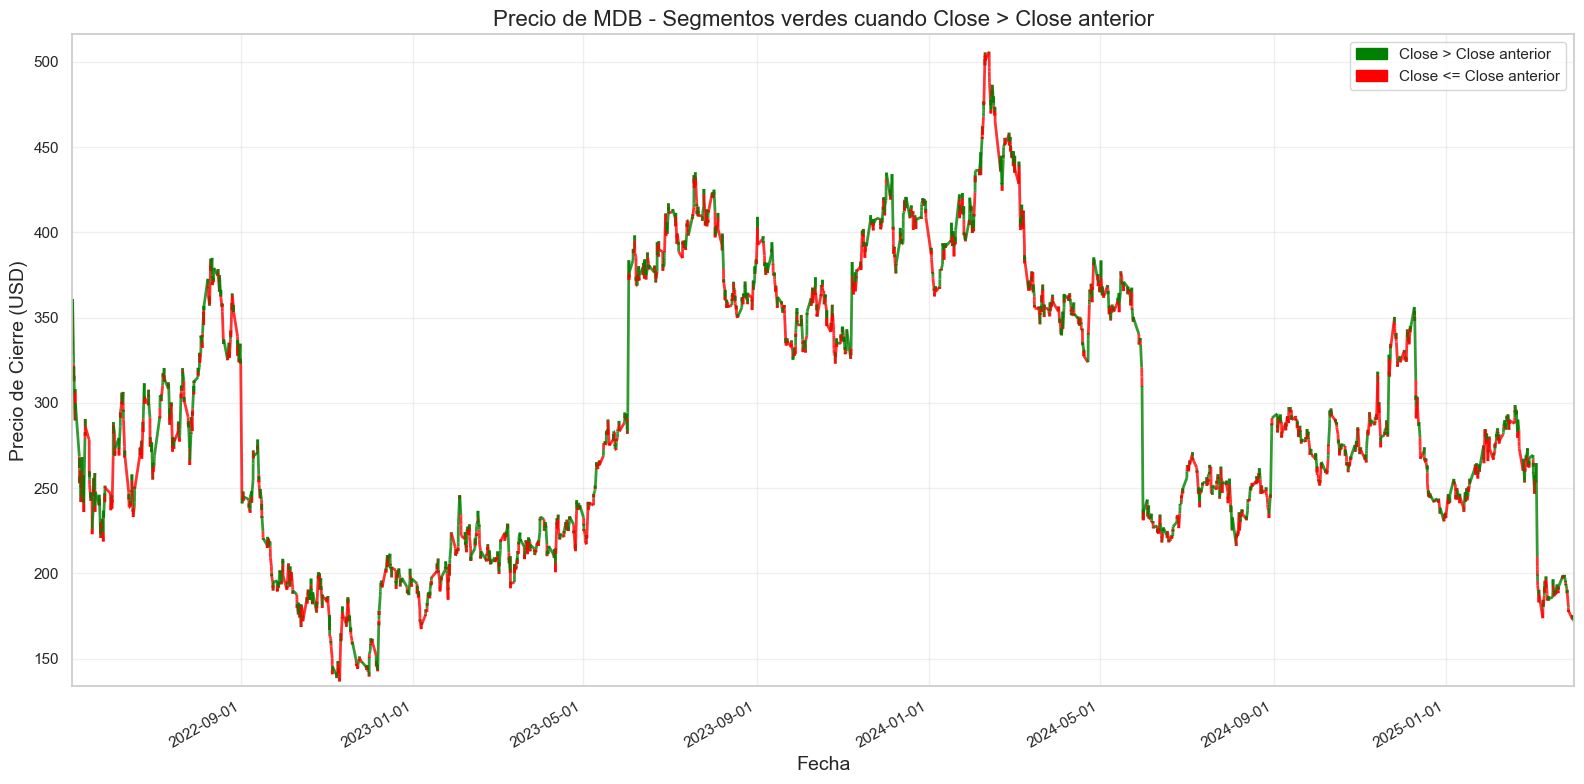

In [392]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection

# Configurar el tama√±o del gr√°fico
plt.figure(figsize=(16, 8))

# Preparar los datos para segmentos coloreados
dates = mdates.date2num(data_2w['Date'])
points = np.array([dates, data_2w['Close']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Crear un mapa de colores para los segmentos (verde cuando Volumen_Color_Num=1, gris cuando=0)
colors = ['green' if val == 1 else 'red' for val in data_2w['Volumen_Color_Num'][:-1]]

# Crear la colecci√≥n de l√≠neas
lc = LineCollection(segments, colors=colors, linewidth=2, alpha=0.8)

# Configurar el gr√°fico
plt.gca().add_collection(lc)
plt.xlim(data_2w['Date'].min(), data_2w['Date'].max())
plt.ylim(data_2w['Close'].min()*0.98, data_2w['Close'].max()*1.02)

# Configurar t√≠tulo y etiquetas
plt.title(f'Precio de {ticker} - Segmentos verdes cuando Close > Close anterior', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio de Cierre (USD)', fontsize=14)

# Formatear el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

# Crear leyenda
green_patch = mpatches.Patch(color='green', label='Close > Close anterior')
gray_patch = mpatches.Patch(color='red', label='Close <= Close anterior')
plt.legend(handles=[green_patch, gray_patch])

# Mostrar cuadr√≠cula
plt.grid(True, alpha=0.3)

# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

In [393]:
def calculate_indicators(data):
    # ===================== üìå MEDIAS M√ìVILES =====================
    data["EMA12"] = data["Close"].ewm(span=12, adjust=False).mean()
    data["EMA26"] = data["Close"].ewm(span=26, adjust=False).mean()
    data["EMA50"] = data["Close"].ewm(span=50, adjust=False).mean()
    data["SMA50"] = data["Close"].rolling(window=50).mean()

    # ===================== üî• BOLLINGER BANDS =====================
    data["BB_upper"] = (data["Close"].rolling(window=20).mean()+ 2 * data["Close"].rolling(window=20).std())
    data["BB_lower"] = (data["Close"].rolling(window=20).mean()- 2 * data["Close"].rolling(window=20).std())
    data["BBW"] = (data["BB_upper"] - data["BB_lower"]) / data["Close"]  # Ancho de BB

    # ===================== üìä VOLUMEN =====================
    data["Volume_MA"] = data["Volume"].rolling(window=20).mean()
    data["Vol_Ratio_10h"] = data["Volume"] / data["Volume"].rolling(window=10).mean()

    # ===================== üîÑ CAMBIOS PORCENTUALES =====================
    data["Hourly_Return"] = data["Close"].pct_change() * 100
    data["Cumulative_Return"] = (data["Close"].pct_change(periods=5) * 100)  # Cambio acumulado en 5 horas

    # ===================== üìà MACD =====================
    data["MACD"] = data["EMA12"] - data["EMA26"]
    data["MACD_Signal"] = data["MACD"].ewm(span=9, adjust=False).mean()

    # ===================== üìä RSI =====================
    data["RSI"] = ta.momentum.rsi(data["Close"], window=14)

    # ===================== üìâ ATR =====================
    data["ATR"] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)

    # ===================== üìä ADX (√çndice de Direcci√≥n Media) =====================
    data["ADX"] = ta.trend.adx(data["High"], data["Low"], data["Close"], window=14)

    # ===================== üîÑ ESTOC√ÅSTICO =====================
    data["Stoch_K"] = ta.momentum.stoch(data["High"], data["Low"], data["Close"], window=14, smooth_window=3)
    data["Stoch_D"] = ta.momentum.stoch_signal(data["High"], data["Low"], data["Close"], window=14, smooth_window=3)

    # ===================== üî• MOMENTUM =====================
    data["MOM"] = ta.momentum.roc(data["Close"], window=10)

    # ===================== üîé OBV (On-Balance Volume) =====================
    data["OBV"] = ta.volume.on_balance_volume(data["Close"], data["Volume"])

    # ===================== üí∞ CMF (Chaikin Money Flow) =====================
    data["CMF"] = ta.volume.chaikin_money_flow(data["High"], data["Low"], data["Close"], data["Volume"], window=20)

    # Eliminar filas con NaN generadas por indicadores
    data.dropna(inplace=True)

    return data


# Aplicar la funci√≥n al dataframe
data_2w = calculate_indicators(data_2w)

# Mostrar primeras filas con indicadores
print(data_2w.head())

Price                      Date       Close        High         Low  \
49    2022-05-13 13:30:00+00:00  279.230011  284.350006  257.079987   
50    2022-05-13 14:30:00+00:00  279.130005  281.119995  274.190002   
51    2022-05-13 15:30:00+00:00  281.329987  284.470001  278.024994   
52    2022-05-13 16:30:00+00:00  282.859985  285.054993  279.970001   
53    2022-05-13 17:30:00+00:00  280.589996  283.920013  277.929993   

Price        Open  Volume  Day  Month  Hour  Year  ...      MACD  MACD_Signal  \
49     257.679993  832881   13      5    13  2022  ... -6.458792   -10.438006   
50     279.230011  289031   13      5    14  2022  ... -3.744914    -9.099388   
51     279.500000  253699   13      5    15  2022  ... -1.400483    -7.559607   
52     281.470398  367408   13      5    16  2022  ...  0.574334    -5.932819   
53     282.779999  172558   13      5    17  2022  ...  1.933928    -4.359469   

Price        RSI        ATR        ADX    Stoch_K    Stoch_D        MOM  \
49     59.9

In [394]:
# üìå Asegurar que 'Date' sea de tipo datetime
data_2w["Date"] = pd.to_datetime(data_2w["Date"])

# üìå Calcular el cambio de RSI en una semana
data_2w["RSI_change_1w"] = data_2w["RSI"] - data_2w["RSI"].shift(70)
data_2w["RSI_change_2w"] = data_2w["RSI"] - data_2w["RSI"].shift(140)
data_2w["ADX_change_1w"] = data_2w["ADX"] - data_2w["ADX"].shift(70)
data_2w["ADX_change_2w"] = data_2w["ADX"] - data_2w["ADX"].shift(140)
data_2w["Volume_MA_change_1w"] = data_2w["Volume_MA"] - data_2w["Volume_MA"].shift(70)

In [395]:
# ===================== üìå CAMBIO PORCENTUAL PASADO =====================
data_2w["Past_Change_1d"] = ((data_2w["Close"] - data_2w["Close"].shift(7)) / data_2w["Close"].shift(7) * 100)
data_2w["Past_Change_2d"] = ((data_2w["Close"] - data_2w["Close"].shift(14)) / data_2w["Close"].shift(14) * 100)
data_2w["Past_Change_1w"] = ((data_2w["Close"] - data_2w["Close"].shift(35)) / data_2w["Close"].shift(35) * 100)
data_2w["Past_Change_2w"] = ((data_2w["Close"] - data_2w["Close"].shift(70)) / data_2w["Close"].shift(70) * 100)

data_2w["Past_Change_1m"] = ((data_2w["Close"] - data_2w["Close"].shift(140)) / data_2w["Close"].shift(140) * 100)
data_2w["Past_Change_2m"] = ((data_2w["Close"] - data_2w["Close"].shift(280)) / data_2w["Close"].shift(280) * 100)
data_2w["Past_Change_3m"] = ((data_2w["Close"] - data_2w["Close"].shift(420)) / data_2w["Close"].shift(420) * 100)
data_2w["Past_Change_6m"] = ((data_2w["Close"] - data_2w["Close"].shift(840)) / data_2w["Close"].shift(840) * 100)

# ===================== üìå CAMBIO PORCENTUAL FUTURO (2 SEMANAS) =====================
data_2w["Future_Change_2w"] = ((data_2w["Close"].shift(-70) - data_2w["Close"]) / data_2w["Close"] * 100)

In [396]:

# ===================== üìå FUNCI√ìN PARAAR CAMBIOS =====================
def classify_change(percentage, percentiles):
    if percentage <= percentiles[0]:
        return 0  # Venta Muy Fuerteelif percentage <= percentiles[1]
    elif percentage <= percentiles[1]:
        return 1  # Venta
    else:
        return 2


# ===================== üìå CALCULAR PERCENTILES DIN√ÅMICOS =====================
percentiles_1w = np.percentile(data_2w["Past_Change_1w"].dropna(), [25, 75])
percentiles_2w = np.percentile(data_2w["Past_Change_2w"].dropna(), [30, 70])
percentiles_1m = np.percentile(data_2w["Past_Change_1m"].dropna(), [25, 75])
percentiles_2m = np.percentile(data_2w["Past_Change_2m"].dropna(), [35, 75])
percentiles_3m = np.percentile(data_2w["Past_Change_3m"].dropna(), [35, 75])
percentiles_6m = np.percentile(data_2w["Past_Change_6m"].dropna(), [35, 75])

In [397]:
# ===================== üìå APLICAR CLASIFICACI√ìN =====================
data_2w["Past_Class_1w"] = data_2w["Past_Change_1w"].apply(lambda x: classify_change(x, percentiles_1w))
data_2w["Past_Class_2w"] = data_2w["Past_Change_2w"].apply(lambda x: classify_change(x, percentiles_2w))
data_2w["Past_Class_1m"] = data_2w["Past_Change_1m"].apply(lambda x: classify_change(x, percentiles_1m))
data_2w["Past_Class_2m"] = data_2w["Past_Change_2m"].apply(lambda x: classify_change(x, percentiles_2m))
data_2w["Past_Class_2m"] = data_2w["Past_Change_2m"].apply(lambda x: classify_change(x, percentiles_3m))
data_2w["Past_Class_2m"] = data_2w["Past_Change_2m"].apply(lambda x: classify_change(x, percentiles_6m))

data_2w["Future_Class_2w"] = data_2w["Future_Change_2w"].apply(lambda x: classify_change(x, percentiles_2w))

data_2w["Volatility_Spike_VH"] = (data_2w["Past_Change_2w"] <= percentiles_2w[0]).astype(int)
data_2w["Volatility_Spike_H"] = (data_2w["Past_Change_2w"] <= percentiles_2w[1]).astype(int)
data_2w["Volatility_Spike_I"] = (data_2w["Past_Change_2w"] <= percentiles_2w[1]).astype(int)

data_2w["Volatility_Spike_VH_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[0]).astype(int)
data_2w["Volatility_Spike_H_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[1]).astype(int)
data_2w["Volatility_Spike_I_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[1]).astype(int)


# ===================== üìå MOSTRAR RESULTADOS =====================
print("Percentiles de cambios pasados (2 semanas):", percentiles_2w)

Percentiles de cambios pasados (2 semanas): [-5.05150151  6.14672297]


In [398]:
def mark_previous_hours(data, column_name, percentiles, horas_a_marcar=84):
    # Crear las nuevas columnas e inicializarlas con 0
    data[f"previousd_strongsell"] = 0
    data[f"previousd_strongbuy"] = 0

    # Iterar sobre los datos para marcar las horas previas
    for i in range(horas_a_marcar, len(data)-7):  # Comenzamos desde el √≠ndice de horas_a_marcar
        # Verificar si el cambio porcentual pasado cae por debajo del percentil 15 (fuerte ca√≠da)
        if data[column_name].iloc[i] <= percentiles[0]:
            # Marcar las horas previas como 1 en 'previousd_strongsell'
            data.loc[data.index[i - horas_a_marcar : i], "previousd_strongsell"] = 1

        # Verificar si el cambio porcentual pasado es mayor que el percentil 58 (subida moderada)
        if data[column_name].iloc[i] >= percentiles[1]:
            # Marcar las horas previas como 1 en 'previousd_buy'
            data.loc[data.index[i - horas_a_marcar : i], "previousd_strongbuy"] = 1

    # Devolver el DataFrame con las nuevas columnas
    return data


data_2w = mark_previous_hours(data_2w, "Past_Change_2w", percentiles_2w, 84)

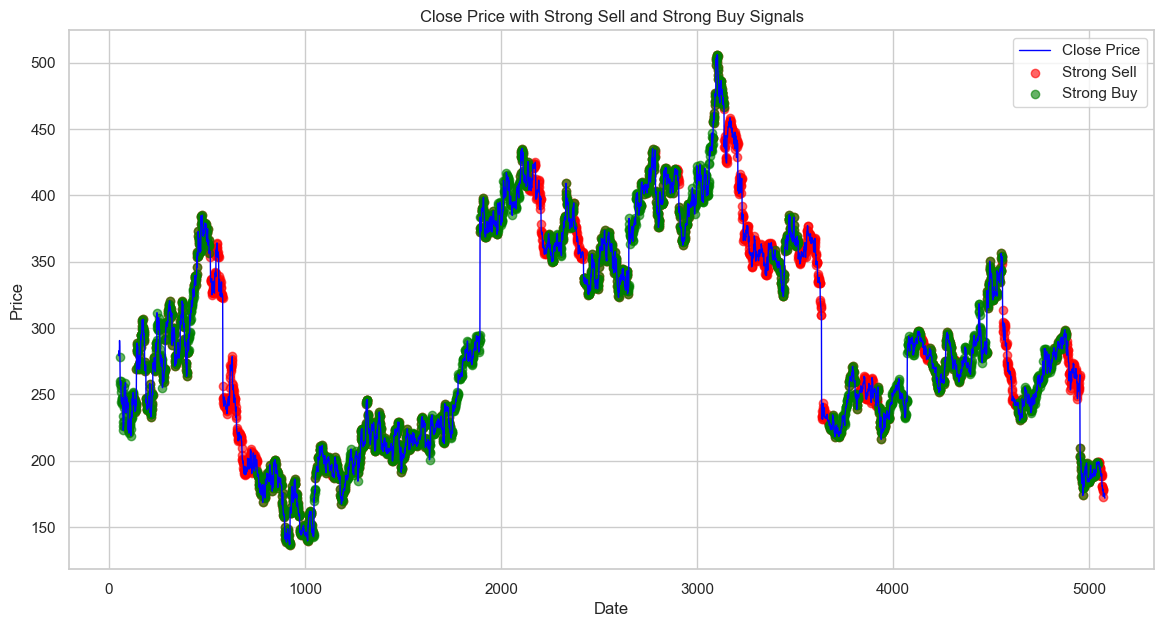

In [399]:
import matplotlib.pyplot as plt

# Graficar 'Close'
plt.figure(figsize=(14, 7))
plt.plot(data_2w['Close'], label='Close Price', color='blue', linewidth=1)

# Marcar los puntos de 'previousd_strongsell' en rojo y 'previousd_strongbuy' en verde
plt.scatter(data_2w.index[data_2w['previousd_strongsell'] == 1], 
            data_2w['Close'][data_2w['previousd_strongsell'] == 1], 
            marker='o', color='red', label='Strong Sell', alpha=0.6)

plt.scatter(data_2w.index[data_2w['previousd_strongbuy'] == 1], 
            data_2w['Close'][data_2w['previousd_strongbuy'] == 1], 
            marker='o', color='green', label='Strong Buy', alpha=0.6)

# A√±adir leyenda y t√≠tulos
plt.title('Close Price with Strong Sell and Strong Buy Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Mostrar el gr√°fico
plt.show()


In [400]:
print(data_2w["previousd_strongsell"].value_counts())
print(data_2w["previousd_strongbuy"].value_counts())

previousd_strongsell
1    3873
0    1159
Name: count, dtype: int64
previousd_strongbuy
1    3847
0    1185
Name: count, dtype: int64


In [401]:
def classify_trend(percentage, percentiles):
    if percentage <= percentiles[0]:  # Por debajo del percentil 25
        return 0  # Tendencia negativa
    elif percentage <= percentiles[1]:  # Entre percentil 25 y 75
        return 1  # Tendencia neutral
    else:  # Por encima del percentil 75
        return 2  # Tendencia positiva

percentiles_trend_1w = np.percentile(data_2w["Past_Change_1w"].dropna(), [35, 65])
percentiles_trend_2w = np.percentile(data_2w["Past_Change_2w"].dropna(), [30, 70])
percentiles_trend_1m = np.percentile(data_2w["Past_Change_1m"].dropna(), [30, 70])
percentiles_trend_2m = np.percentile(data_2w["Past_Change_2m"].dropna(), [30, 70])
percentiles_trend_3m = np.percentile(data_2w["Past_Change_3m"].dropna(), [35, 65])
percentiles_trend_6m = np.percentile(data_2w["Past_Change_6m"].dropna(), [40, 60])

In [402]:
import pandas as pd
import numpy as np

def assign_period_trends(data, fecha_col='Date', close_col='Close'):
    # Ordenar por fecha (ascendente)
    data = data.sort_values(fecha_col).copy()
    
    # Definir periodos en t√©rminos de n√∫mero de observaciones
    periods = {
        '6m': 840,
        '3m': 420,
        '2m': 280,
        '1m': 140,
        '2w': 70,
        '1w': 35
    }
    
    # Obtener el n√∫mero total de registros
    num_data = len(data)
    
    # Para cada periodo, dividir los datos en bloques de tama√±o espec√≠fico
    for period_name, period_size in periods.items():
        trend_col = f'Period_Trend_{period_name}'
        data[trend_col] = np.nan
        
        # Dividir los datos en bloques de tama√±o period_size
        for i in range(0, num_data, period_size):
            # Seleccionar los datos en este bloque
            period_data = data.iloc[i:i+period_size]
            
            # Si el bloque tiene al menos dos datos, calcular la tendencia
            if len(period_data) >= 2:
                start_price = period_data[close_col].iloc[0]
                end_price = period_data[close_col].iloc[-1]
                change_pct = ((end_price - start_price) / start_price) * 100
                
                # Clasificar la tendencia (usando percentiles globales)
                if period_name == '1w':
                    trend = classify_trend(change_pct, percentiles_trend_1w)
                elif period_name == '2w':
                    trend = classify_trend(change_pct, percentiles_trend_2w)
                elif period_name == '1m':
                    trend = classify_trend(change_pct, percentiles_trend_1m)
                elif period_name == '2m':
                    trend = classify_trend(change_pct, percentiles_trend_2m)
                elif period_name == '3m':
                    trend = classify_trend(change_pct, percentiles_trend_3m)
                elif period_name == '6m':
                    trend = classify_trend(change_pct, percentiles_trend_6m)
                
                # Asignar la tendencia a todo el bloque
                data.loc[period_data.index, trend_col] = trend
    
    return data

# Aplicar la funci√≥n
data_2w = assign_period_trends(data_2w)


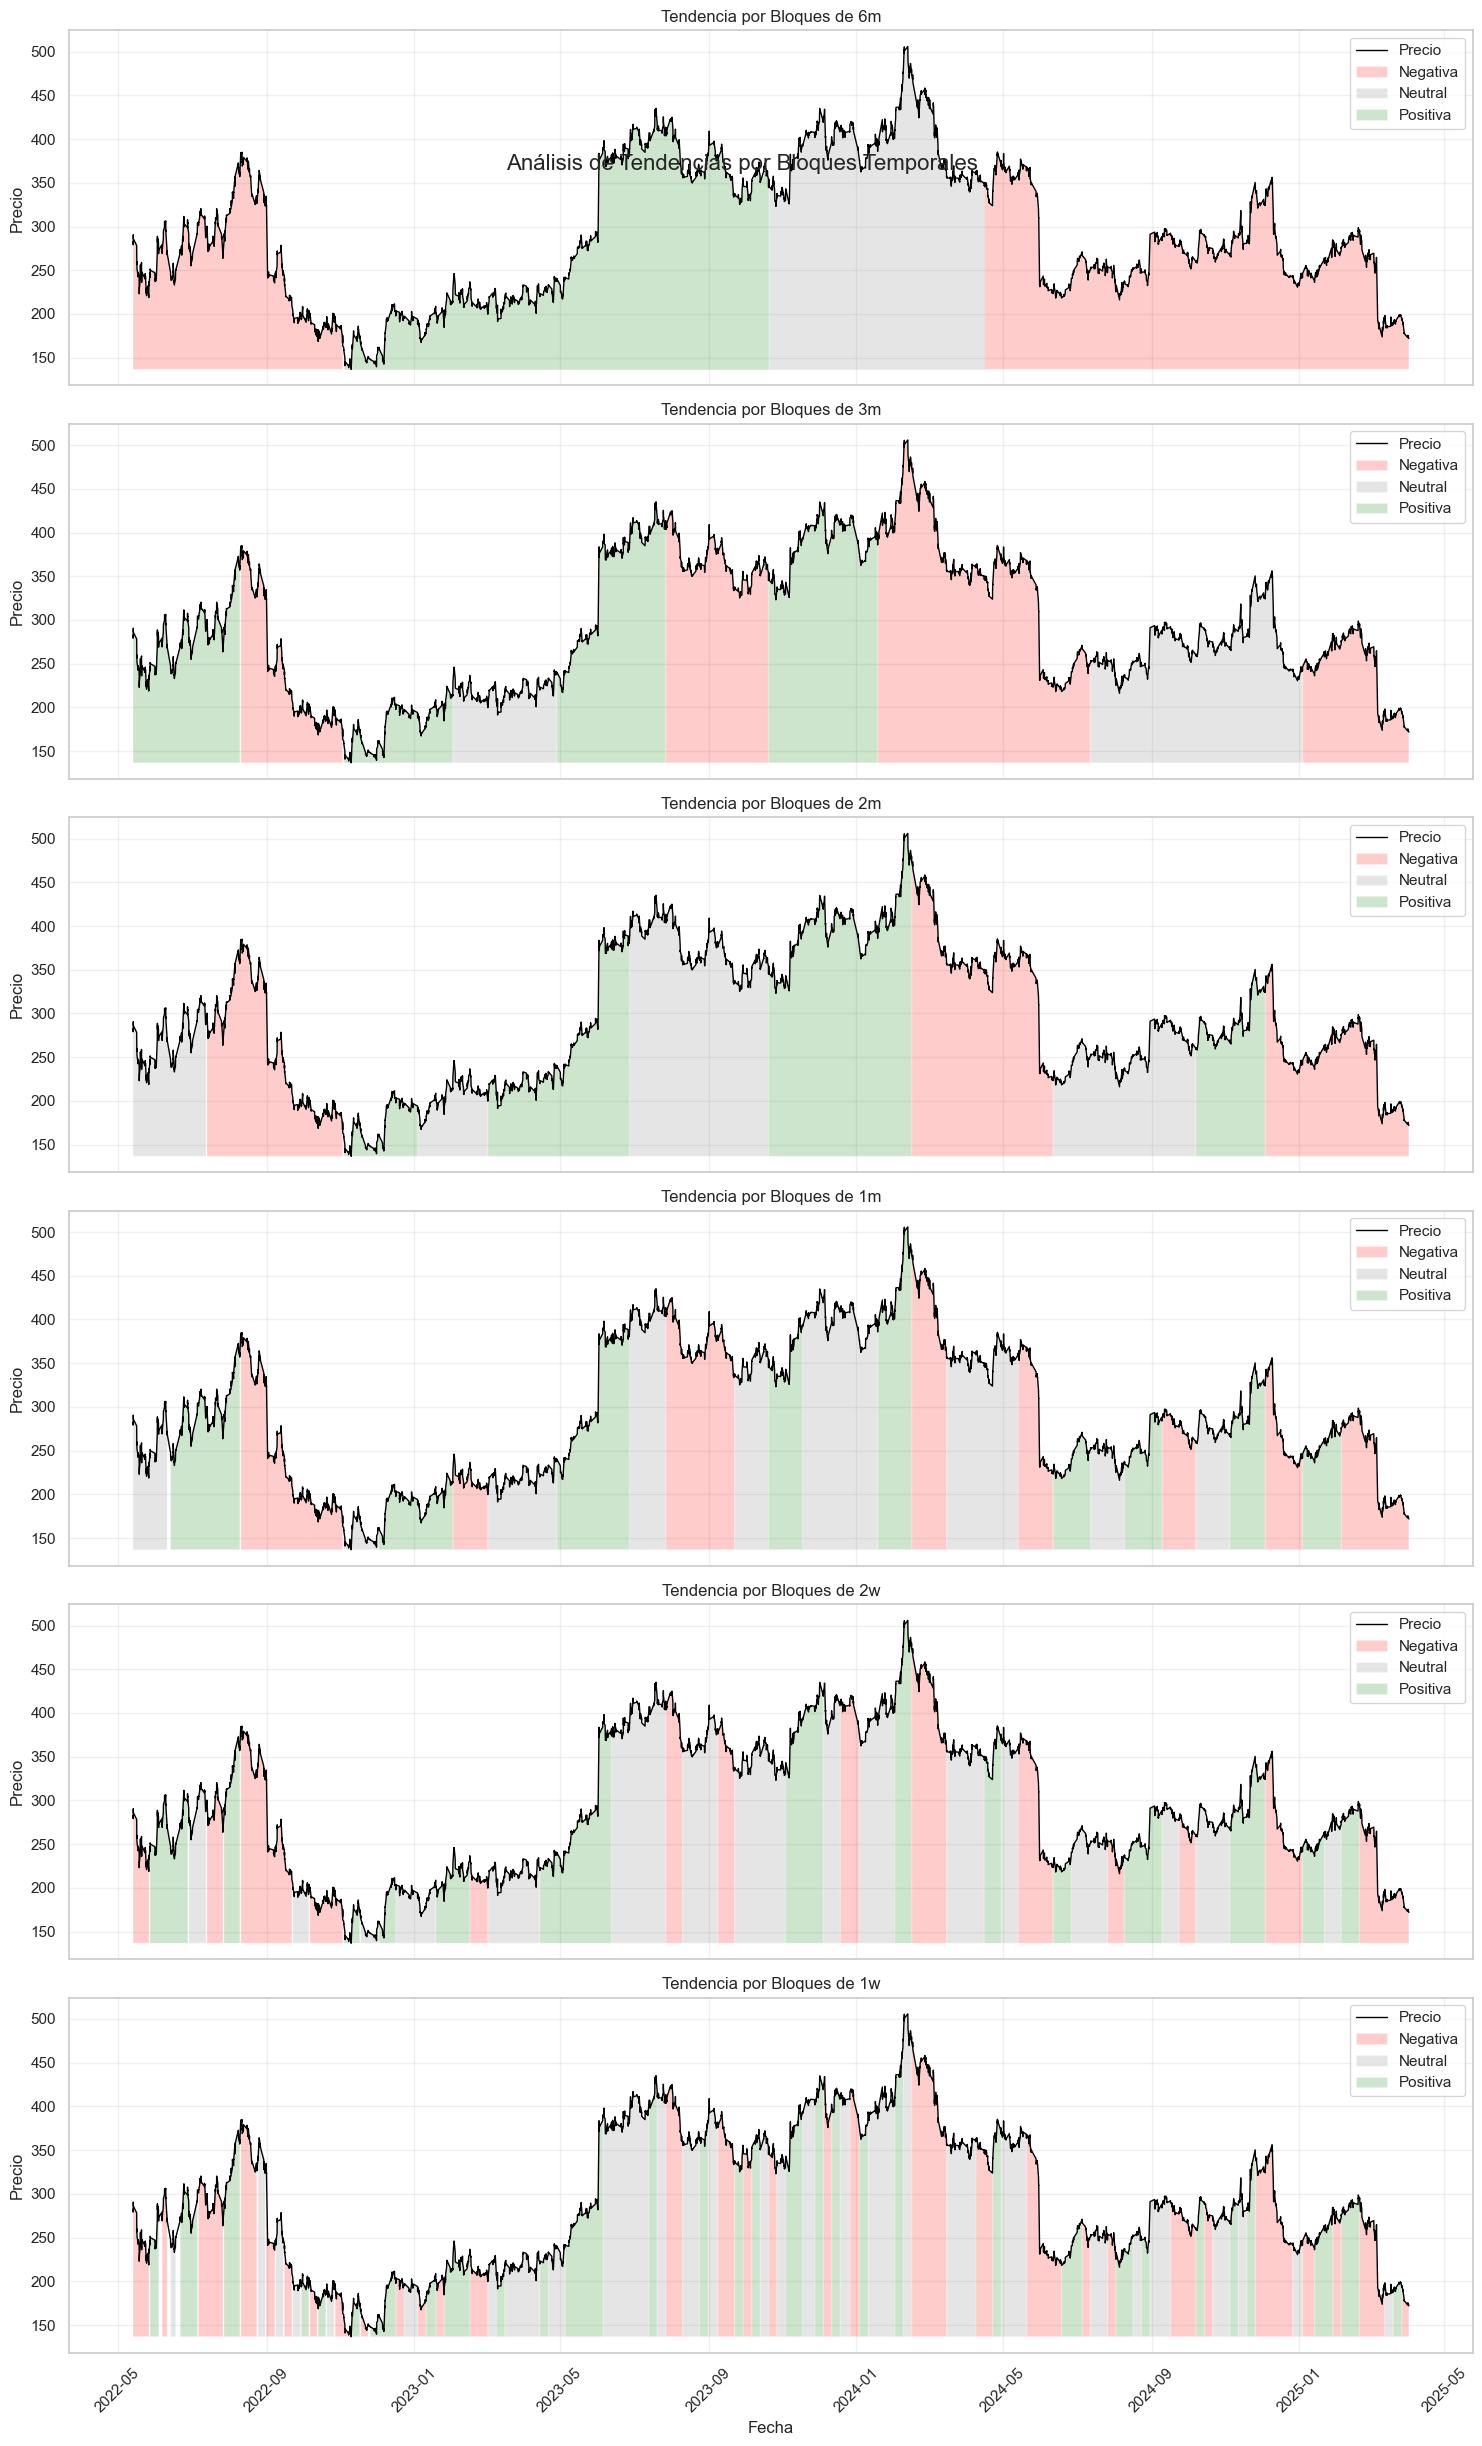

In [403]:
# Definir periodos de forma global
periods = {
    '6m': 840,
    '3m': 420,
    '2m': 280,
    '1m': 140,
    '2w': 70,
    '1w': 36
}

# Llamar a la funci√≥n con la variable global
data_2w = assign_period_trends(data_2w)

# Crear figura
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 25), sharex=True)

# Graficar cada periodo
for ax, (period_name, _) in zip(axes, periods.items()):
    trend_col = f'Period_Trend_{period_name}'
    
    # Graficar precio
    ax.plot(data_2w['Date'], data_2w['Close'], color='black', linewidth=1, label='Precio')
    
    # Colorear por tendencia
    for trend_val, color in [(0, 'red'), (1, 'gray'), (2, 'green')]:
        mask = data_2w[trend_col] == trend_val
        ax.fill_between(data_2w['Date'], 
                       data_2w['Close'].min(), 
                       data_2w['Close'],
                       where=mask,
                       facecolor=color,
                       alpha=0.2,
                       label=['Negativa', 'Neutral', 'Positiva'][trend_val])
    
    ax.set_title(f'Tendencia por Bloques de {period_name}', fontsize=12)
    ax.set_ylabel('Precio')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.xlabel('Fecha')
plt.suptitle('An√°lisis de Tendencias por Bloques Temporales', fontsize=16, y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [404]:
from scipy.signal import argrelextrema

def mark_multi_window_trade_signals(data, windows=[14,21,35, 70, 140, 420]):
    """
    Detecta picos importantes en diferentes escalas de tiempo.
    - windows: Lista con los diferentes per√≠odos a analizar.
    """
    data = data.copy()
    
    for window in windows:
        # Crear nuevas columnas para cada ventana
        buy_col = f"buy_signal_w{window}"
        sell_col = f"sell_signal_w{window}"
        data[buy_col] = 0
        data[sell_col] = 0

        # Encontrar m√≠nimos y m√°ximos locales en la ventana dada
        min_indexes = argrelextrema(data["Close"].values, np.less, order=window)[0]  # V normales (comprar)
        max_indexes = argrelextrema(data["Close"].values, np.greater, order=window)[0]  # V invertidas (vender)

        # Marcar picos con margen de ¬±1 d√≠a
        for i in min_indexes:
            data.loc[data.index[max(0, i - 1) : min(len(data), i + 2)], buy_col] = 1
        for i in max_indexes:
            data.loc[data.index[max(0, i - 1) : min(len(data), i + 2)], sell_col] = 1

    return data

# Aplicar la funci√≥n a los datos
data_2w = mark_multi_window_trade_signals(data_2w, windows=[14,21,35, 70, 140, 420])

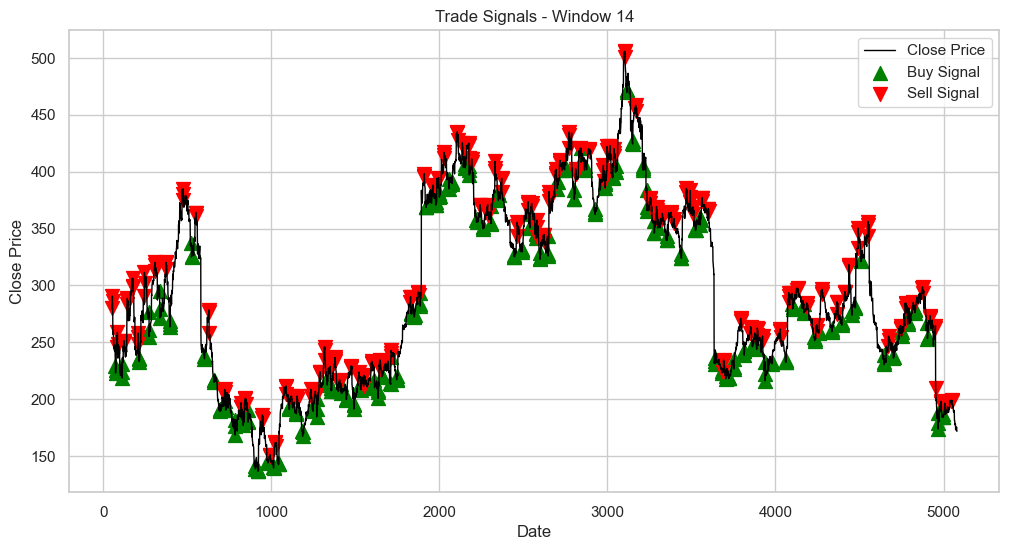

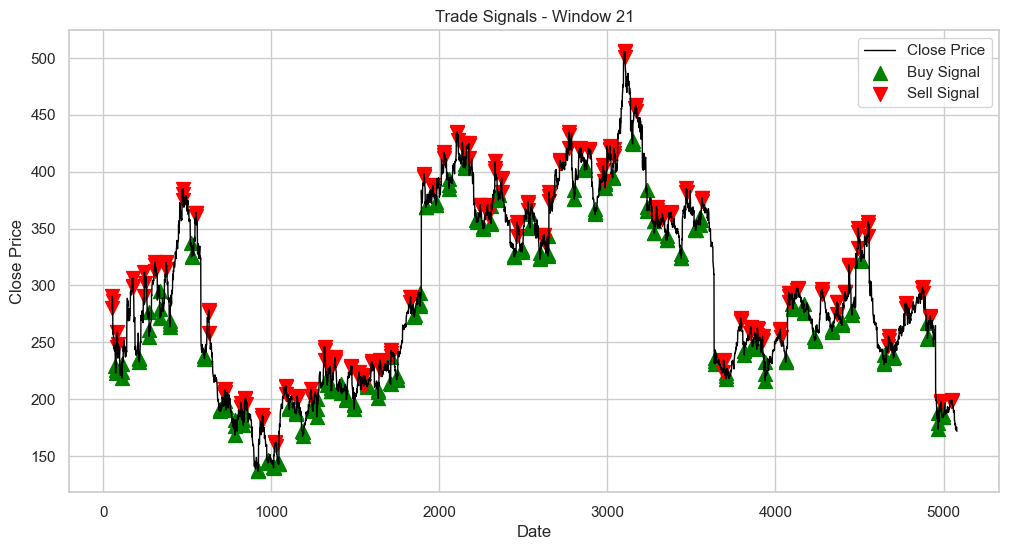

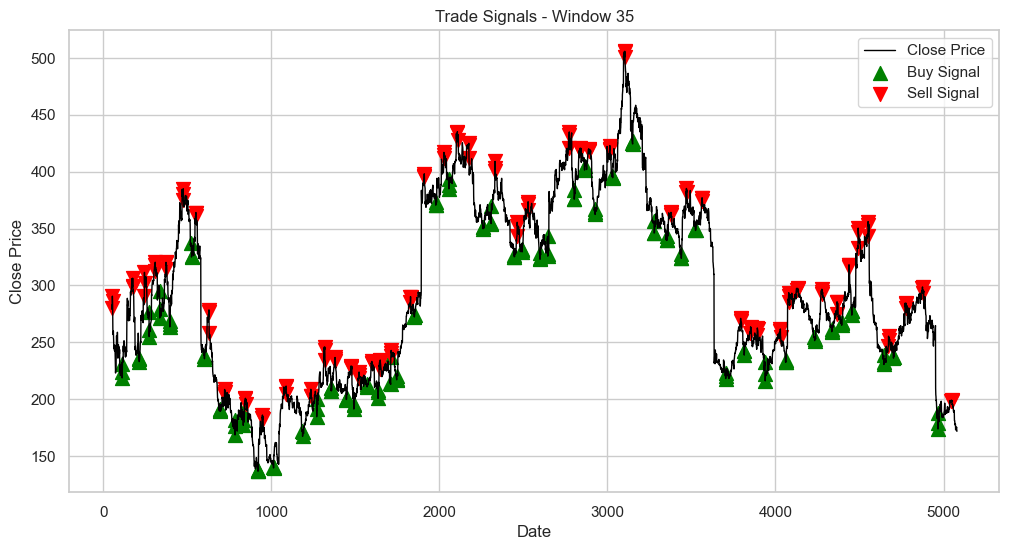

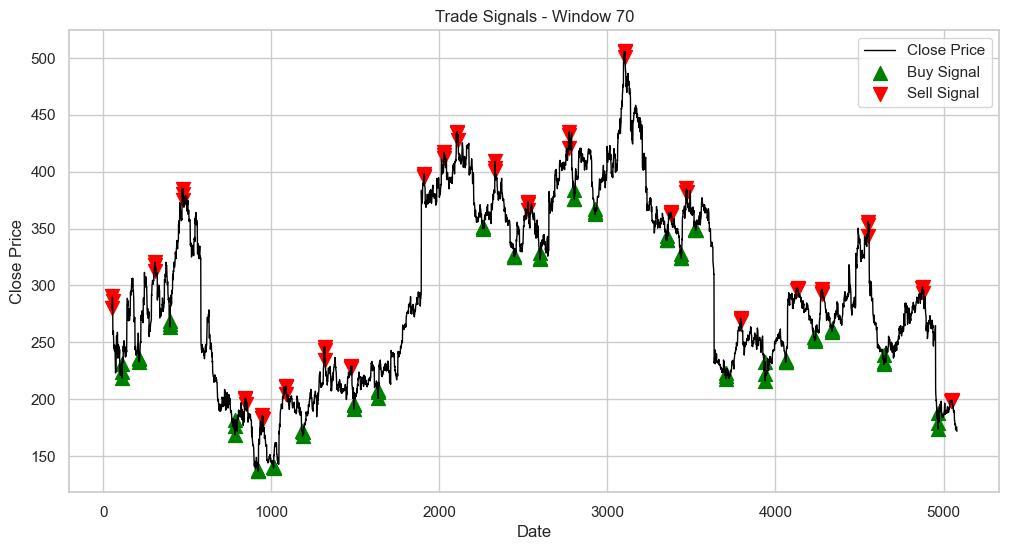

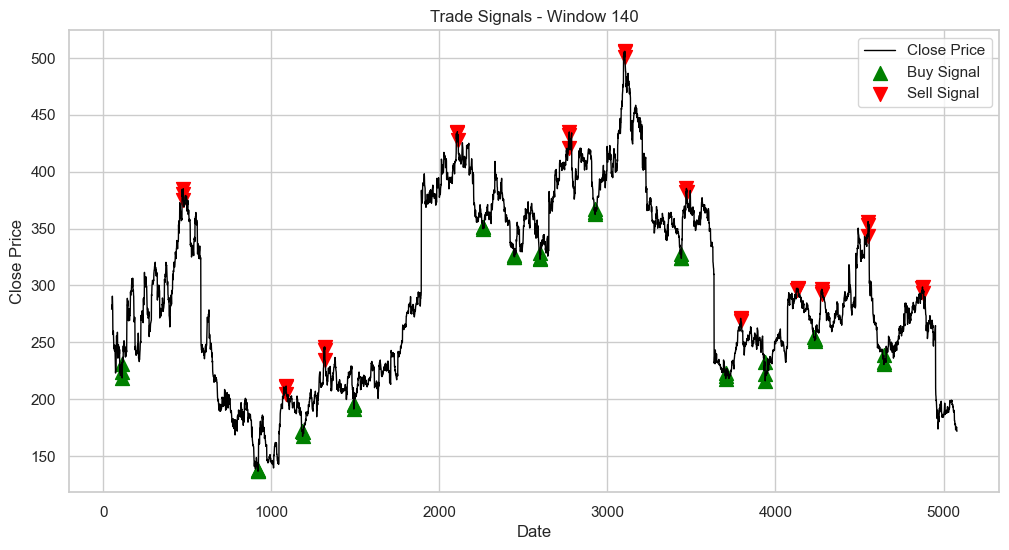

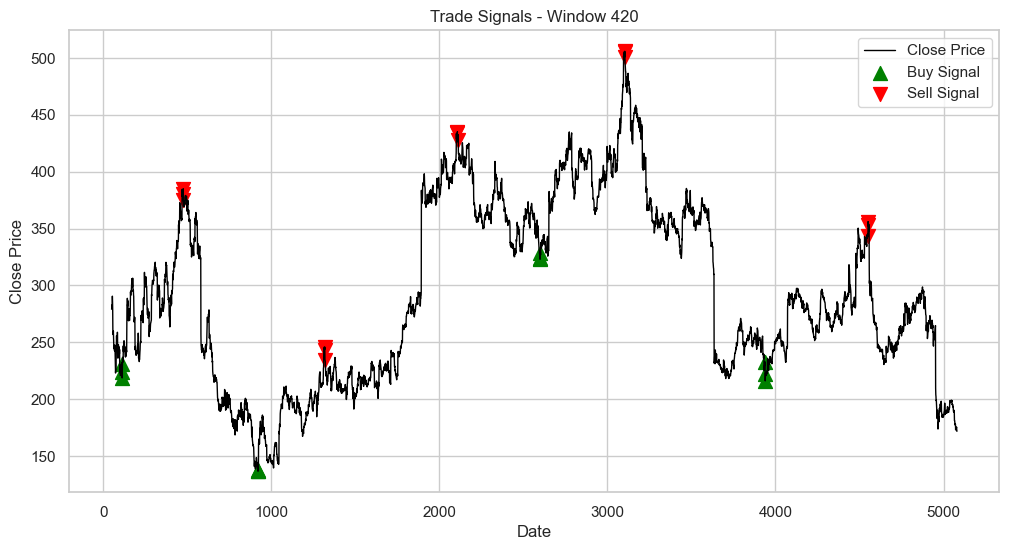

In [405]:
import matplotlib.pyplot as plt

def plot_trade_signals(data, windows=[14,21,35, 70, 140, 420]):
    """
    Genera una gr√°fica por cada ventana de tiempo mostrando los buy y sell signals.
    """
    for window in windows:
        buy_col = f"buy_signal_w{window}"
        sell_col = f"sell_signal_w{window}"

        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data["Close"], label="Close Price", color="black", linewidth=1)

        # Puntos de compra (verde)
        buy_signals = data[data[buy_col] == 1]
        plt.scatter(buy_signals.index, buy_signals["Close"], color="green", marker="^", label="Buy Signal", s=100)

        # Puntos de venta (rojo)
        sell_signals = data[data[sell_col] == 1]
        plt.scatter(sell_signals.index, sell_signals["Close"], color="red", marker="v", label="Sell Signal", s=100)

        plt.title(f"Trade Signals - Window {window}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.show()

# Llamar a la funci√≥n para graficar
plot_trade_signals(data_2w, windows=[14,21,35, 70, 140, 420])

In [406]:
# Calcular la matriz de correlaci√≥n
correlation_matrix = data_2w.corr()
# üîπ Obtener las variables con correlaci√≥n d√©bil con 'Future_Class_2w'
low_corr_features = correlation_matrix.index[
    correlation_matrix["Future_Class_2w"].between(-0.08, 0.08)
].difference(["Date", "Close"])

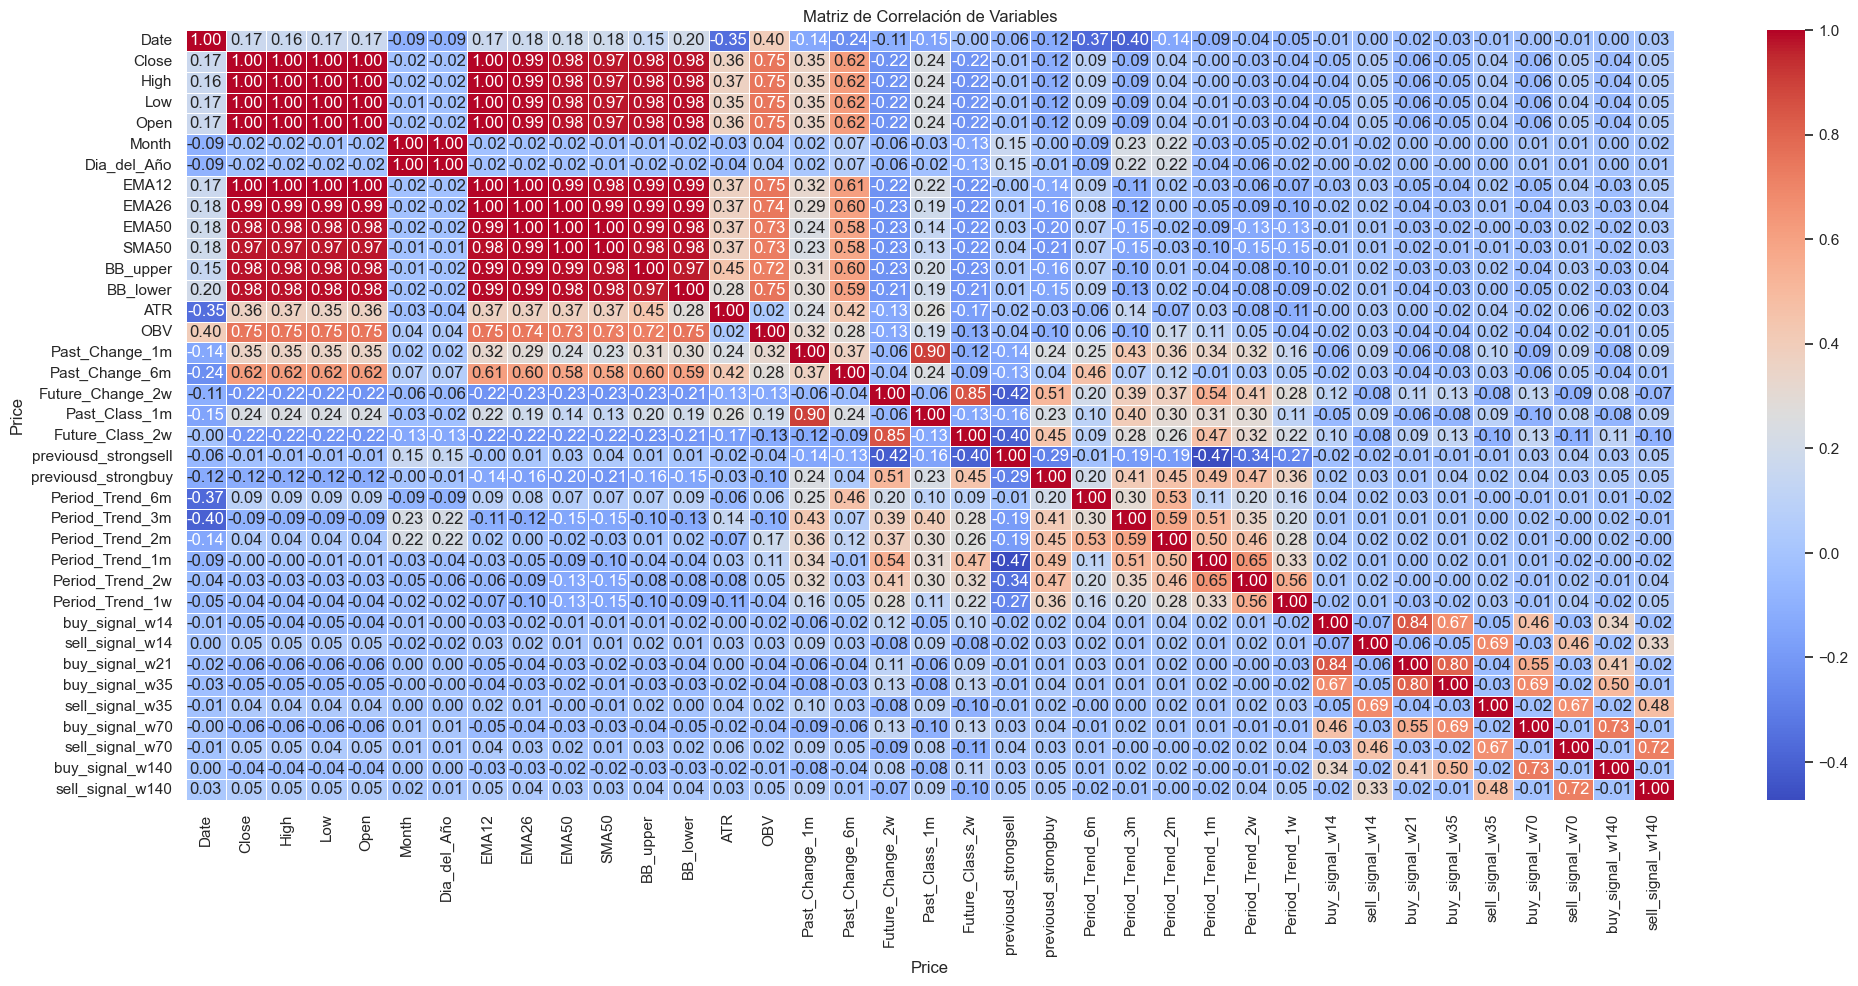

In [407]:
import seaborn as sns
import matplotlib.pyplot as plt
# üìå Eliminar las columnas con baja correlaci√≥n
data_view = data_2w.drop(columns=data_2w[low_corr_features])

correlation_matrix = data_view.corr()

# Configurar la figura
plt.figure(figsize=(24, 10))

# Crear un heatmap con Seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# T√≠tulo del gr√°fico
plt.title("Matriz de Correlaci√≥n de Variables")

# Mostrar la gr√°fica
plt.show()

In [408]:
data_2w.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Day', 'Month',
       'Hour', 'Year', 'Dia_de_la_Semana', 'Dia_del_A√±o', 'Volumen_Color_Num',
       'EMA12', 'EMA26', 'EMA50', 'SMA50', 'BB_upper', 'BB_lower', 'BBW',
       'Volume_MA', 'Vol_Ratio_10h', 'Hourly_Return', 'Cumulative_Return',
       'MACD', 'MACD_Signal', 'RSI', 'ATR', 'ADX', 'Stoch_K', 'Stoch_D', 'MOM',
       'OBV', 'CMF', 'RSI_change_1w', 'RSI_change_2w', 'ADX_change_1w',
       'ADX_change_2w', 'Volume_MA_change_1w', 'Past_Change_1d',
       'Past_Change_2d', 'Past_Change_1w', 'Past_Change_2w', 'Past_Change_1m',
       'Past_Change_2m', 'Past_Change_3m', 'Past_Change_6m',
       'Future_Change_2w', 'Past_Class_1w', 'Past_Class_2w', 'Past_Class_1m',
       'Past_Class_2m', 'Future_Class_2w', 'Volatility_Spike_VH',
       'Volatility_Spike_H', 'Volatility_Spike_I', 'Volatility_Spike_VH_m',
       'Volatility_Spike_H_m', 'Volatility_Spike_I_m', 'previousd_strongsell',
       'previousd_strongbuy', 'Period_Tren

<Figure size 1500x1000 with 0 Axes>

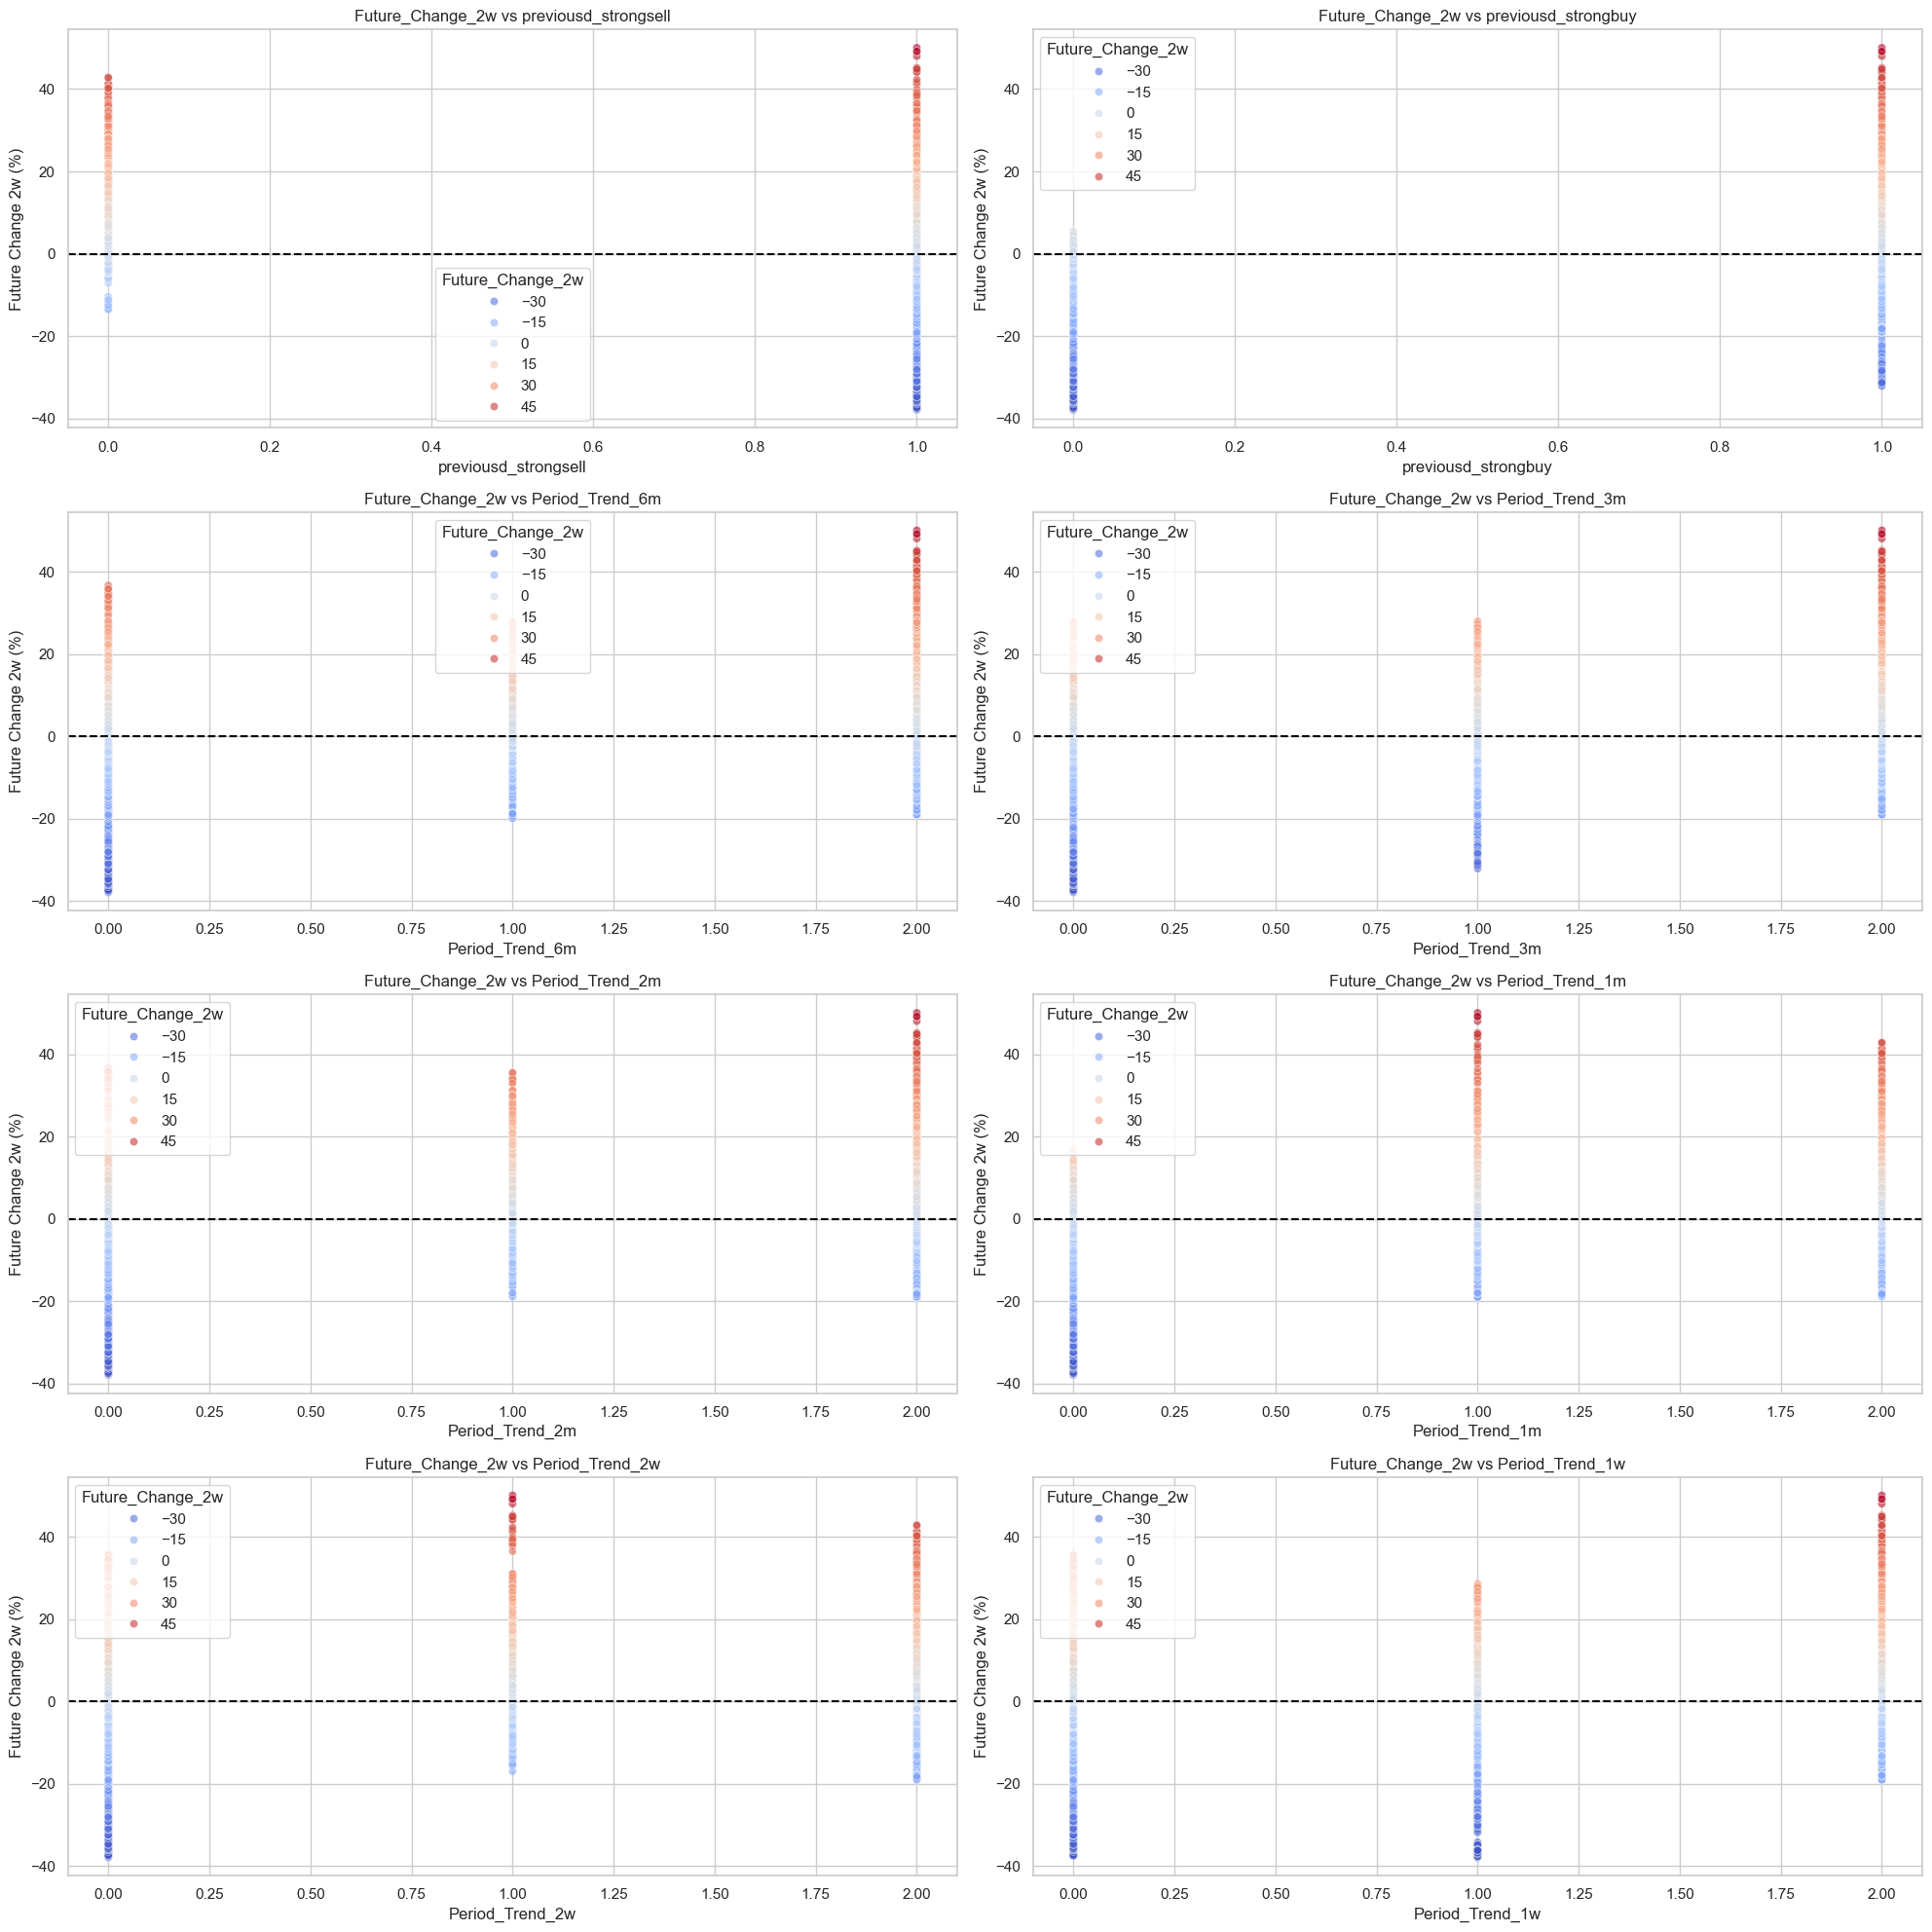

In [409]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuraci√≥n inicial
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid", palette="muted")

# Variables a analizar
variables = [
    'previousd_strongsell', 
    'previousd_strongbuy',
    'Period_Trend_6m',
    'Period_Trend_3m',
    'Period_Trend_2m',
    'Period_Trend_1m',
    'Period_Trend_2w',
    'Period_Trend_1w'
]

# Crear subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.flatten()

# Graficar cada variable vs Future_Change_2w
for i, var in enumerate(variables):
    if data_2w[var].dtype in ['int64', 'float64']:
        # Para variables num√©ricas
        sns.scatterplot(
            data=data_2w,
            x=var,
            y='Future_Change_2w',
            hue='Future_Change_2w',
            palette='coolwarm',
            alpha=0.6,
            ax=axes[i]
        )
        axes[i].axhline(0, color='black', linestyle='--')
    else:
        # Para variables categ√≥ricas
        sns.boxplot(
            data=data_2w,
            x=var,
            y='Future_Change_2w',
            palette='Set2',
            ax=axes[i]
        )
        axes[i].axhline(0, color='black', linestyle='--')
    
    axes[i].set_title(f'Future_Change_2w vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Future Change 2w (%)')

plt.tight_layout()
plt.show()


In [410]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Eliminar valores nulos
data_train_2w = data_2w.dropna()

# Preparar los datos
X = data_train_2w.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y = data_train_2w["Future_Class_2w"]

# Normalizaci√≥n de las caracter√≠sticas usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_2w = scaler.fit_transform(X)

# Definir la fecha de corte (por ejemplo, 2024-01-01)
fecha_corte = "2024-05-01"

# Crear el conjunto de entrenamiento (hasta la fecha de corte)
train_data = data_train_2w[data_train_2w["Date"] < fecha_corte]
test_data = data_train_2w[data_train_2w["Date"] >= fecha_corte]

# Preparar los datos de entrenamiento y prueba
X_train_2w = train_data.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y_train_2w = train_data["Future_Class_2w"]
X_test_2w = test_data.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y_test_2w = test_data["Future_Class_2w"]

# Inicializar los modelos
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,
    ),
    "XGBoost": xgb.XGBClassifier(
        eval_metric="mlogloss",
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        min_child_weight=5,
        random_state=42,
        n_jobs=-1,
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=42,
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective="multiclass",
        num_class=5,
        n_estimators=500,
        learning_rate=0.01,
        max_depth=-1,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        force_col_wise=True,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    )
}

In [411]:
# Entrenar y evaluar cada modelo
predictions_2w = {}
model_metrics = {}

for name, model in models.items():
    print(f"Entrenando modelo: {name}")

    # Entrenar el modelo con el conjunto de entrenamiento completo
    model.fit(X_train_2w, y_train_2w)

    # Hacer predicciones sobre el conjunto de prueba
    y_pred = model.predict(X_test_2w)

    # Guardar predicciones y m√©tricas
    predictions_2w[name] = y_pred
    report_2w = classification_report(
        y_test_2w, y_pred, output_dict=True, zero_division=1
    )
    model_metrics[name] = report_2w

# Imprimir los resultados
for name, metrics in model_metrics.items():
    print(f"\nReporte de clasificaci√≥n para el modelo: {name}")
    print(metrics)

Entrenando modelo: Random Forest
Entrenando modelo: XGBoost
Entrenando modelo: Gradient Boosting
Entrenando modelo: LightGBM

Reporte de clasificaci√≥n para el modelo: Random Forest
{'0': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 502.0}, '1': {'precision': 0.398406374501992, 'recall': 0.16835016835016836, 'f1-score': 0.23668639053254437, 'support': 594.0}, '2': {'precision': 0.33490566037735847, 'recall': 0.9976580796252927, 'f1-score': 0.5014714537963508, 'support': 427.0}, 'accuracy': 0.345370978332239, 'macro avg': {'precision': 0.5777706782931169, 'recall': 0.3886694159918204, 'f1-score': 0.2460526147762984, 'support': 1523.0}, 'weighted avg': {'precision': 0.5788956687034243, 'recall': 0.345370978332239, 'f1-score': 0.23290875032657463, 'support': 1523.0}}

Reporte de clasificaci√≥n para el modelo: XGBoost
{'0': {'precision': 0.6590909090909091, 'recall': 0.23107569721115537, 'f1-score': 0.3421828908554572, 'support': 502.0}, '1': {'precision': 0.37264957264957

In [412]:
import json

# Guardar m√©tricas en un archivo JSON
with open("model_metrics.json", "w") as f:
    json.dump(model_metrics, f, indent=4)

In [413]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Evaluar modelos con Accuracy, F1-score y Kappa
model_scores_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    accuracy = accuracy_score(y_test_2w, y_pred_2w)
    f1 = f1_score(y_test_2w, y_pred_2w, average="weighted")  # F1 ponderado
    kappa = cohen_kappa_score(y_test_2w, y_pred_2w)  # Cohen's Kappa

    model_scores_2w[model_name] = {"accuracy": accuracy, "f1_score": f1, "kappa": kappa}

# Ordenar modelos por precisi√≥n (puedes cambiar a 'f1_score' o 'kappa' si prefieres)
sorted_models_2w = sorted(
    model_scores_2w.items(), key=lambda x: x[1]["accuracy"], reverse=True
)

# Imprimir los 3 mejores modelos
print("üîπ Top 3 Modelos Basados en Precisi√≥n:")
for i, (model_name, scores) in enumerate(sorted_models_2w[:3]):
    print(f"{i + 1}. {model_name} - Precisi√≥n: {scores['accuracy']:.4f} | F1-Score: {scores['f1_score']:.4f} | Kappa: {scores['kappa']:.4f}")

üîπ Top 3 Modelos Basados en Precisi√≥n:
1. XGBoost - Precisi√≥n: 0.4846 | F1-Score: 0.4475 | Kappa: 0.2328
2. LightGBM - Precisi√≥n: 0.4846 | F1-Score: 0.4440 | Kappa: 0.2278
3. Gradient Boosting - Precisi√≥n: 0.4458 | F1-Score: 0.4040 | Kappa: 0.1874


<Figure size 1000x600 with 0 Axes>

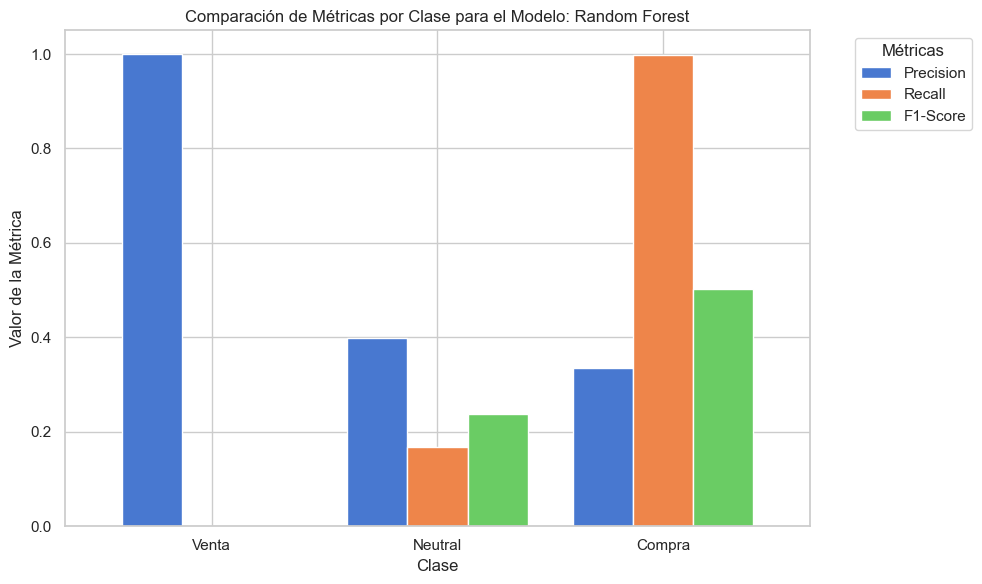

<Figure size 1000x600 with 0 Axes>

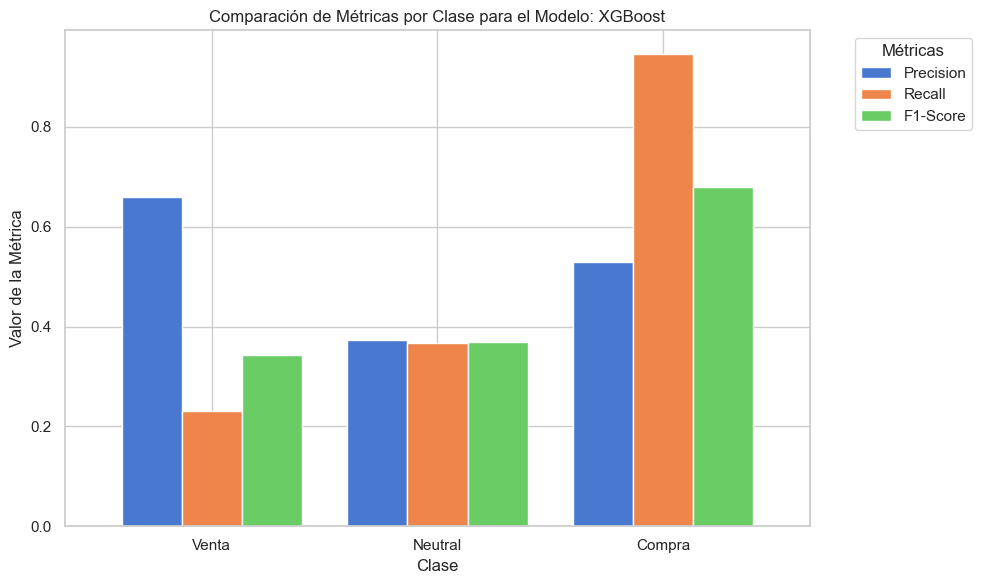

<Figure size 1000x600 with 0 Axes>

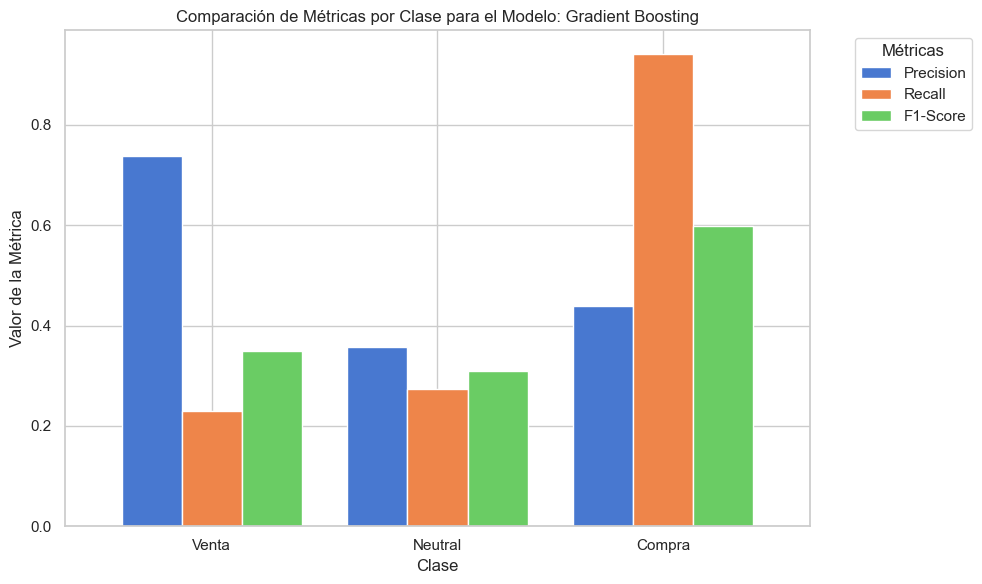

<Figure size 1000x600 with 0 Axes>

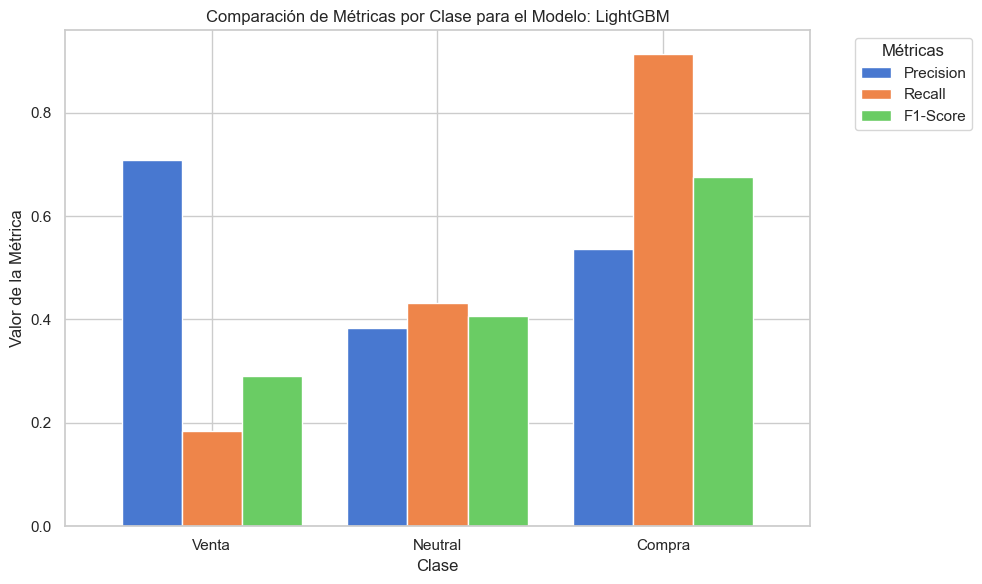

In [414]:
# Crear un DataFrame vac√≠o para almacenar las m√©tricas por clase
class_metrics = {}

# Definir el diccionario para mapear las etiquetas num√©ricas a las de clase
label_mapping = {
    0: "Venta",
    1: "Neutral",
    2: "Compra"
}

# Extraer las m√©tricas por clase para cada modelo
for model_name, y_pred_2w in predictions_2w.items():
    # Obtener el reporte de clasificaci√≥n por clase
    report_2w = classification_report(y_test_2w, y_pred_2w, output_dict=True, zero_division=1)
    
    # Filtrar las m√©tricas relevantes (precision, recall, f1-score) para cada clase
    for label in ['0', '1', '2']:  # 0: Venta, 1: Neutral, 2: Compra
        class_label = label_mapping[int(label)]  # Convertir el n√∫mero a la etiqueta correspondiente
        class_metrics.setdefault(model_name, {})[class_label] = {
            "Precision": report_2w[label]['precision'],
            "Recall": report_2w[label]['recall'],
            "F1-Score": report_2w[label]['f1-score']
        }

# Crear una gr√°fica para cada modelo
for model_name, metrics in class_metrics.items():
    # Convertir las m√©tricas por clase a un DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

    # Crear una figura para el gr√°fico
    plt.figure(figsize=(10, 6))

    # Graficar las m√©tricas de precisi√≥n, recall y f1-score por clase para el modelo actual
    metrics_df.plot(kind='bar', figsize=(10, 6), width=0.8)

    # A√±adir t√≠tulo y etiquetas
    plt.title(f'Comparaci√≥n de M√©tricas por Clase para el Modelo: {model_name}')
    plt.xlabel('Clase')
    plt.ylabel('Valor de la M√©trica')
    plt.xticks(rotation=0)  # No rotar las etiquetas para que se vean bien
    plt.legend(title='M√©tricas', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajustar la visualizaci√≥n del gr√°fico para que todo se vea bien
    plt.tight_layout()

    # Mostrar la gr√°fica
    plt.show()

In [415]:
# Mostrar la cantidad de cada predicci√≥n por modelo
prediction_counts_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    unique, counts = np.unique(y_pred_2w, return_counts=True)  # Contar la frecuencia de cada predicci√≥n
    prediction_counts_2w[model_name] = dict(zip(unique, counts))

In [416]:
# Crear un DataFrame para almacenar las predicciones y los valores reales
comparison_df_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    # Crear un DataFrame con las predicciones y las clases reales
    comparison_df_2w[model_name] = pd.DataFrame(
        {
            "Real": y_test_2w,  # Valores reales
            "Predicci√≥n": y_pred_2w,  # Predicciones del modelo
        }
    )

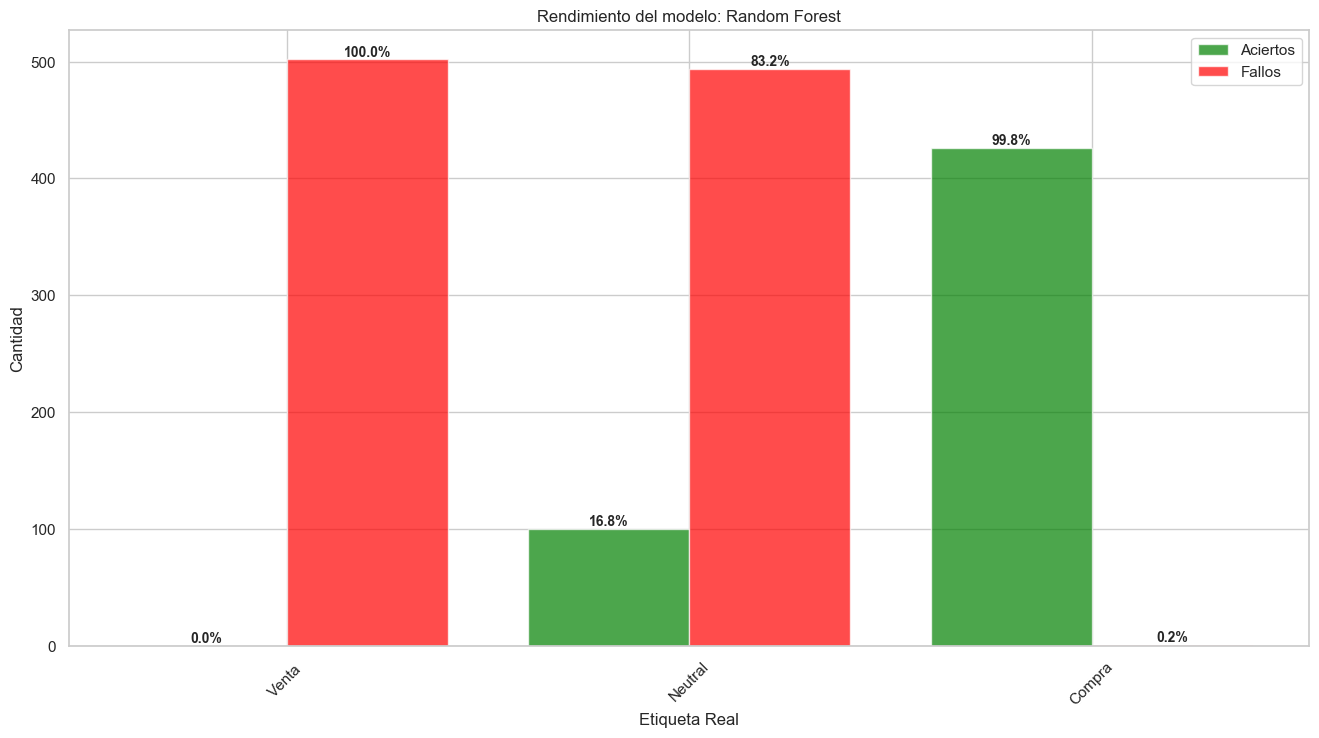

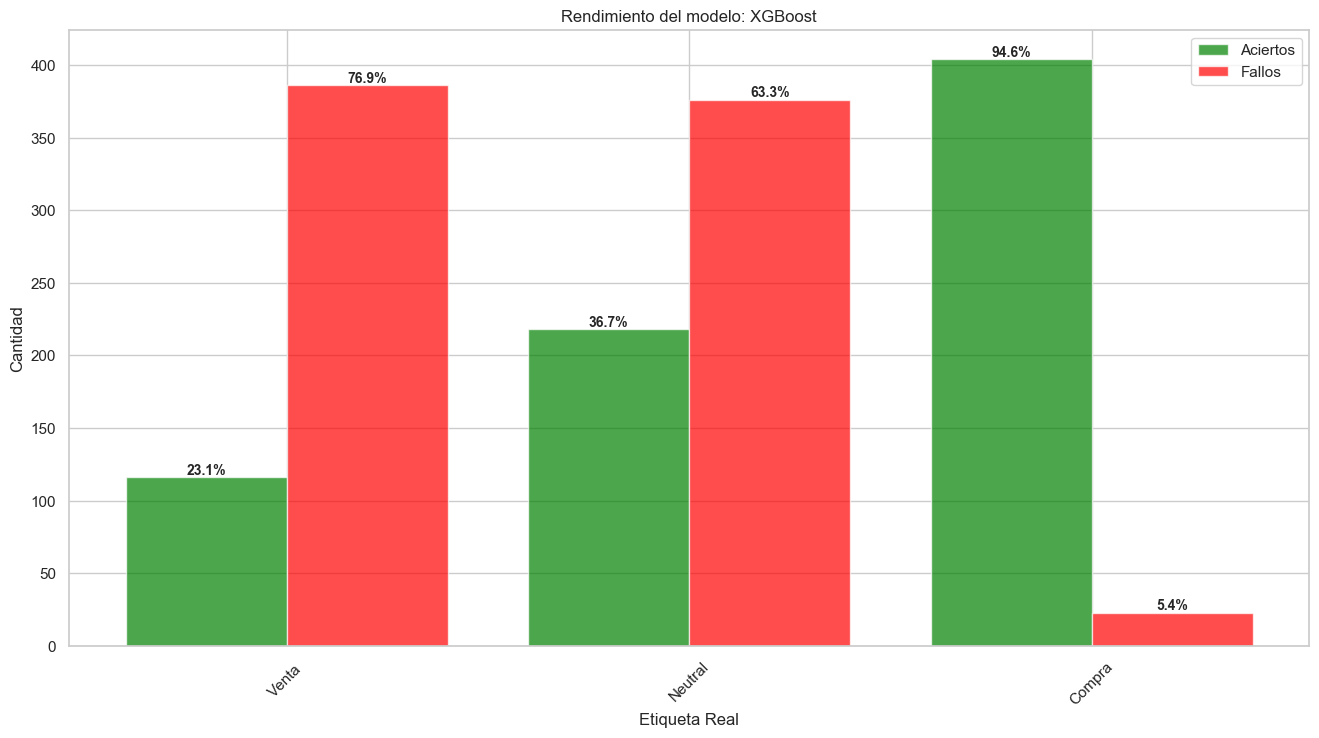

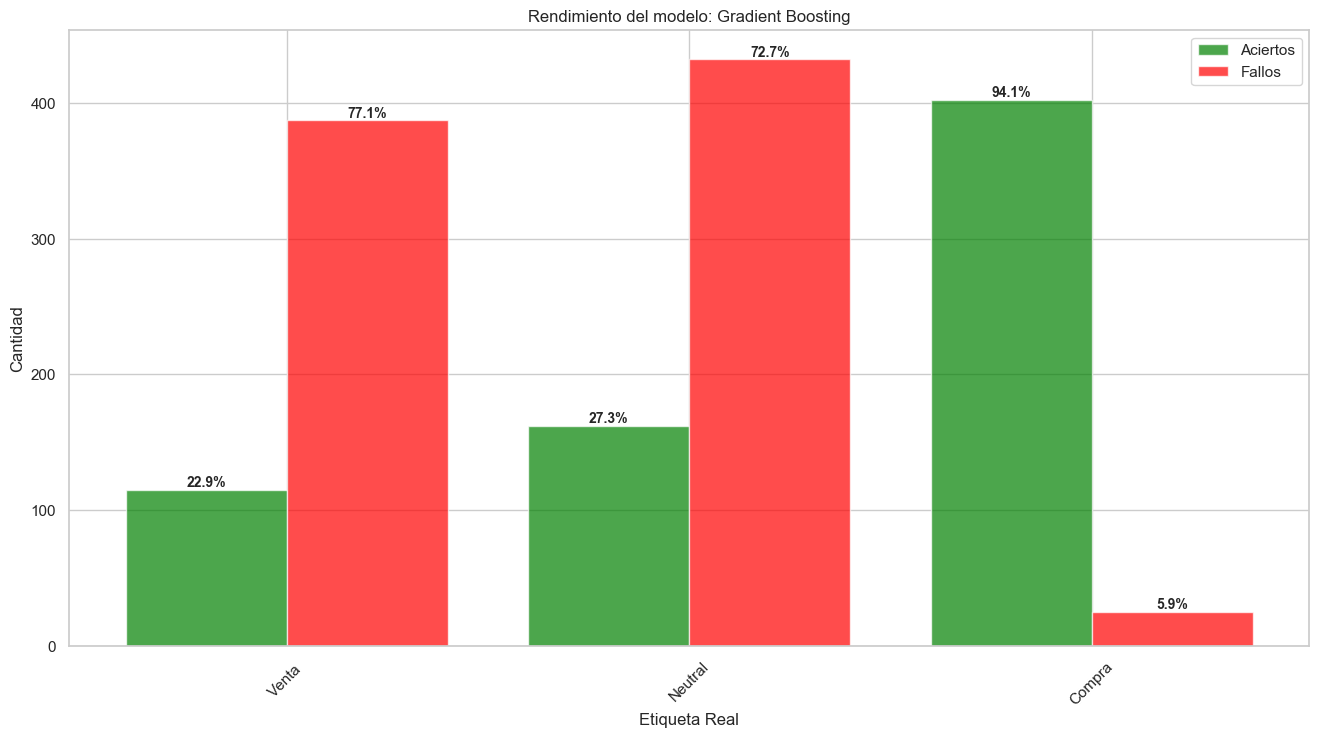

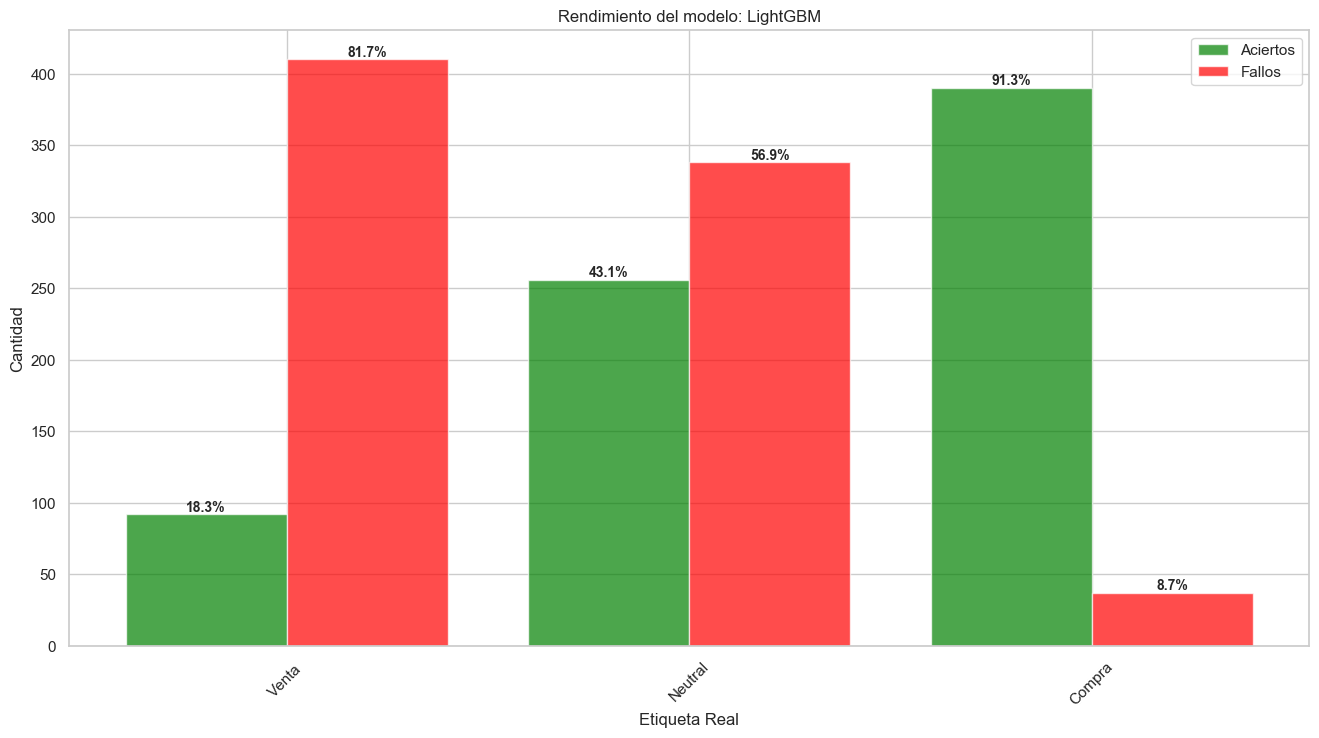

In [417]:
# üîπ Diccionario para mapear n√∫meros a etiquetas (con orden espec√≠fico)
label_mapping = {
    0: "Venta ",
    1: "Neutral",
    2: "Compra",
}

# Lista ordenada de etiquetas
ordered_labels = list(label_mapping.values())

# üîπ Crear un DataFrame para almacenar las comparaciones
comparison_df_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    # Crear DataFrame con valores reales y predicciones
    df = pd.DataFrame({"Real": y_test_2w, "Predicci√≥n": y_pred_2w})

    # Convertir los valores num√©ricos a etiquetas de texto
    df["Real"] = df["Real"].map(label_mapping)
    df["Predicci√≥n"] = df["Predicci√≥n"].map(label_mapping)

    # Definir el orden de las categor√≠as para "Real" y "Predicci√≥n"
    df["Real"] = pd.Categorical(df["Real"], categories=ordered_labels, ordered=True)
    df["Predicci√≥n"] = pd.Categorical(df["Predicci√≥n"], categories=ordered_labels, ordered=True)

    # Guardar en el diccionario
    comparison_df_2w[model_name] = df

# üîπ Crear una gr√°fica para comparar aciertos y errores por cada etiqueta
for model_name, df in comparison_df_2w.items():
    df["Correcto"] = df["Real"] == df["Predicci√≥n"]  # True si acert√≥, False si fall√≥

    # Contar aciertos y errores por etiqueta
    results = (df.groupby(["Real", "Correcto"], observed=False).size().unstack(fill_value=0))

    # Asegurar que las columnas existen y renombrarlas si es necesario
    results = results.rename(columns={True: "Aciertos", False: "Fallos"})

    # Si faltan columnas, agregarlas con 0
    results = results.reindex(columns=["Aciertos", "Fallos"], fill_value=0)

    # Calcular porcentajes
    total_counts = results.sum(axis=1)
    percentages = results.div(total_counts, axis=0) * 100  # Convertir a porcentaje

    # üîπ Gr√°fica con barras separadas (verde a la izquierda, roja a la derecha)
    x = np.arange(len(ordered_labels))  # Posiciones de las etiquetas
    width = 0.4  # Ancho de las barras

    plt.figure(figsize=(16, 8))

    # Barras de aciertos (izquierda)
    bars1 = plt.bar(
        x - width / 2,
        results["Aciertos"],
        width=width,
        color="green",
        alpha=0.7,
        label="Aciertos",
    )

    # Barras de fallos (derecha)
    bars2 = plt.bar(
        x + width / 2,
        results["Fallos"],
        width=width,
        color="red",
        alpha=0.7,
        label="Fallos",
    )

    # üîπ A√±adir los porcentajes sobre cada barra
    for bar, pct1 in zip(bars1, percentages["Aciertos"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{pct1:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    for bar, pct2 in zip(bars2, percentages["Fallos"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{pct2:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # üîπ Formato final de la gr√°fica
    plt.title(f"Rendimiento del modelo: {model_name}")
    plt.xlabel("Etiqueta Real")
    plt.ylabel("Cantidad")
    plt.xticks(x, ordered_labels, rotation=45)  # Etiquetas con rotaci√≥n
    plt.legend()
    plt.show()

In [418]:
# Obtener los datos de ayer (√∫ltima fila)
yesterday_data = data_2w.iloc[-1:]

# Extraer fecha y precio de cierre de ayer
yesterday_date = yesterday_data["Date"].values[0]
yesterday_close = yesterday_data["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
X_yesterday_np = (X_yesterday.to_numpy())  # Convertir a numpy para evitar warnings de Scikit-Learn

# Hacer predicciones con cada modelo
future_predictions = {}

for model_name, model in models.items():
    future_prediction = model.predict(X_yesterday_np)[0]  # Obtener la predicci√≥n num√©rica

    future_predictions[model_name] = (
        f"üìâ Ca√≠da (< {percentiles_2w[0]:.2f}%)"
        if future_prediction == 0
        else (
            f"‚ûñ  Sin cambios significativos ({percentiles_2w[0]:.2f}% a {percentiles_2w[1]:.2f}%)"
            if future_prediction == 1
            else (f"‚ûñ  Sin cambios significativos (>{percentiles_2w[1]:.2f}%)")
        )
    )

# Mostrar los resultados con fecha formateada correctamente
print(f"\nüìÖ Fecha de la √∫ltima observaci√≥n: {pd.to_datetime(yesterday_date).strftime('%Y-%m-%d %H:%M')}")
print(f"üí∞ Precio de cierre: {yesterday_close:.2f} USD\n")

print("üîÆ Predicciones de 'Future_Class_2w' para los datos de ayer:")
for model_name, prediction in future_predictions.items():
    print(f"‚ö° {model_name}: {prediction}")


üìÖ Fecha de la √∫ltima observaci√≥n: 2025-04-01 14:30
üí∞ Precio de cierre: 171.82 USD

üîÆ Predicciones de 'Future_Class_2w' para los datos de ayer:
‚ö° Random Forest: ‚ûñ  Sin cambios significativos (>6.15%)
‚ö° XGBoost: ‚ûñ  Sin cambios significativos (-5.05% a 6.15%)
‚ö° Gradient Boosting: ‚ûñ  Sin cambios significativos (>6.15%)
‚ö° LightGBM: ‚ûñ  Sin cambios significativos (-5.05% a 6.15%)


c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [419]:
import matplotlib.pyplot as plt

# √öltimos 350 registros para graficar historial
data_last_350 = data_2w.tail(500)

# Obtener datos de ayer (√∫ltima fila)
yesterday_data_2w = data_2w.iloc[-1:]
yesterday_date_2w = yesterday_data_2w["Date"].values[0]
yesterday_close_2w = yesterday_data_2w["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday_2w = yesterday_data.drop(
    columns=["Future_Change_2w", "Future_Class_2w", "Date"]
)
X_yesterday_2w_np = X_yesterday.to_numpy()

# Definir cu√°ntos pasos futuros extenderemos la banda
future_steps_2w = 70
last_date = data_last_350["Date"].max()  # √öltima fecha en la data hist√≥rica
future_dates_2w = pd.date_range(start=last_date, periods=future_steps_2w + 1, freq="h")[
    1:
]

In [420]:
def check_prediction_for_specific_day(data, x, periods_ahead=70):
    """
    Verifica la predicci√≥n de los modelos para una fecha espec√≠fica `x` per√≠odos atr√°s
    y su resultado futuro en 'Future_Class_2w', mostrando ambos cierres.
    """
    # Verificar si hay suficientes datos hacia atr√°s
    if x >= len(data):
        print(f"‚ö†Ô∏è No hay suficientes datos para verificar {x} per√≠odos atr√°s.")
        return

    # Obtener los datos de hace `x` per√≠odos
    specific_day_data = data.iloc[-x]  # √öltimos `x` per√≠odos hacia atr√°s
    specific_date = specific_day_data["Date"]

    # Calcular la fecha futura correctamente
    future_index = -x + periods_ahead  # 70 per√≠odos adelante (~2 semanas en 1h)

    if future_index < len(data):
        future_day_data = data.iloc[future_index]
        future_date = future_day_data["Date"]
        close_future = future_day_data["Close"]
    else:
        future_date = "N/A"
        close_future = None  # No hay suficiente data para ver el cierre futuro

    # Seleccionar caracter√≠sticas para el modelo (excluyendo la columna objetivo y la fecha)
    features = [
        col
        for col in data.columns
        if col not in ["Future_Change_2w", "Future_Class_2w", "Date"]
    ]
    X_specific_day = specific_day_data[features]

    # Realizar predicciones con cada modelo
    specific_day_predictions_2w = {}
    for model_name, model in models.items():
        future_prediction = model.predict([X_specific_day])
        specific_day_predictions_2w[model_name] = future_prediction[
            0
        ]  # Guardar la predicci√≥n

    # Obtener la clase real y el cambio futuro
    real_class_future = specific_day_data["Future_Class_2w"]
    real_change_future = specific_day_data["Future_Change_2w"]

    # Determinar en qu√© rango cae el cambio real seg√∫n los percentiles
    real_class_from_change = (
        0
        if real_change_future <= percentiles_2w[0]
        else 1 if real_change_future <= percentiles_2w[1] else 2
    )

    # üìå Mostrar resultados con fecha real y cierres
    print(f"\nüìÖ Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"üí∞ Cierre en la fecha evaluada: {specific_day_data['Close']:.2f} USD")
    print(
        f"üìÖ Fecha futura (2 semanas despu√©s): {future_date if future_date != 'N/A' else 'No disponible'}"
    )

    if close_future is not None:
        print(f"üí∞ Cierre en la fecha futura: {close_future:.2f} USD")

    print(f"üîπ Clase real 'Future_Class_2w': {real_class_future}")
    print(
        f"üîπ Cambio real: {real_change_future:.2f}% -> Clasificado como {real_class_from_change}"
    )

    print(f"\nüìä Percentiles para clasificaci√≥n:")
    for i, perc in enumerate(percentiles_2w):
        print(f"   üîπ Percentil {i}: {perc:.2f}%")

    print("\nüîç Predicciones de los modelos:")
    for model_name, prediction in specific_day_predictions_2w.items():
        resultado = "‚úÖ Acert√≥!" if prediction == real_class_future else "‚ùå No acert√≥."
        print(
            f"   {model_name}: Predicci√≥n = {prediction} | Real = {real_class_future} -> {resultado}"
        )

    # üöÄ Depuraci√≥n si hay errores en la fecha futura
    if isinstance(future_date, str) or future_date.year < 2025:
        print("\n‚ö†Ô∏è Posible error en el c√°lculo de la fecha futura.")
        print(f"   √çndice futuro esperado: {future_index}")
        print(f"   Fecha estimada en DataFrame: {future_date}")


# üîπ **Ejemplo de uso:**
print(data_2w.shape)

check_prediction_for_specific_day(data_2w, x=87)  # Verifica hace 100 per√≠odos (~4-5 d√≠as h√°biles en 1h)

c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(5032, 79)

üìÖ Fecha evaluada: 2025-03-13 19:30:00
üí∞ Cierre en la fecha evaluada: 185.18 USD
üìÖ Fecha futura (2 semanas despu√©s): 2025-03-27 19:30:00+00:00
üí∞ Cierre en la fecha futura: 188.64 USD
üîπ Clase real 'Future_Class_2w': 1
üîπ Cambio real: 1.87% -> Clasificado como 1

üìä Percentiles para clasificaci√≥n:
   üîπ Percentil 0: -5.05%
   üîπ Percentil 1: 6.15%

üîç Predicciones de los modelos:
   Random Forest: Predicci√≥n = 2 | Real = 1 -> ‚ùå No acert√≥.
   XGBoost: Predicci√≥n = 1 | Real = 1 -> ‚úÖ Acert√≥!
   Gradient Boosting: Predicci√≥n = 1 | Real = 1 -> ‚úÖ Acert√≥!
   LightGBM: Predicci√≥n = 1 | Real = 1 -> ‚úÖ Acert√≥!


c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\guille\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



üìÖ Fecha evaluada: 2025-03-17 19:30:00
üí∞ Cierre en la fecha evaluada: 193.03 USD
üìÖ Fecha futura (2 semanas despu√©s): 2025-03-31 19:30:00
üí∞ Cierre en la fecha futura: 175.37 USD
üìà Cambio real en porcentaje: -9.15%

üîç Predicciones de los modelos y precios proyectados:
Random Forest: Predicci√≥n = 2 | Rango esperado = 204.90 - 301.51 USD
üéØ Rango de percentiles: 6.15% - 56.20% -> ‚ùå No acert√≥.
XGBoost: Predicci√≥n = 1 | Rango esperado = 183.28 - 204.90 USD
üéØ Rango de percentiles: -5.05% - 6.15% -> ‚ùå No acert√≥.
Gradient Boosting: Predicci√≥n = 2 | Rango esperado = 204.90 - 301.51 USD
üéØ Rango de percentiles: 6.15% - 56.20% -> ‚ùå No acert√≥.
LightGBM: Predicci√≥n = 1 | Rango esperado = 183.28 - 204.90 USD
üéØ Rango de percentiles: -5.05% - 6.15% -> ‚ùå No acert√≥.


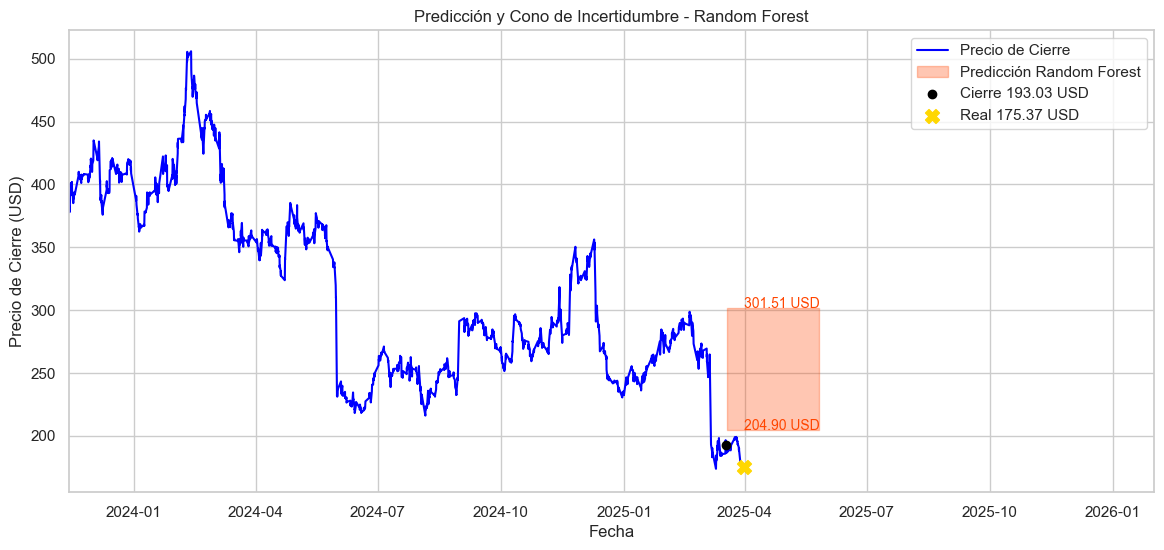

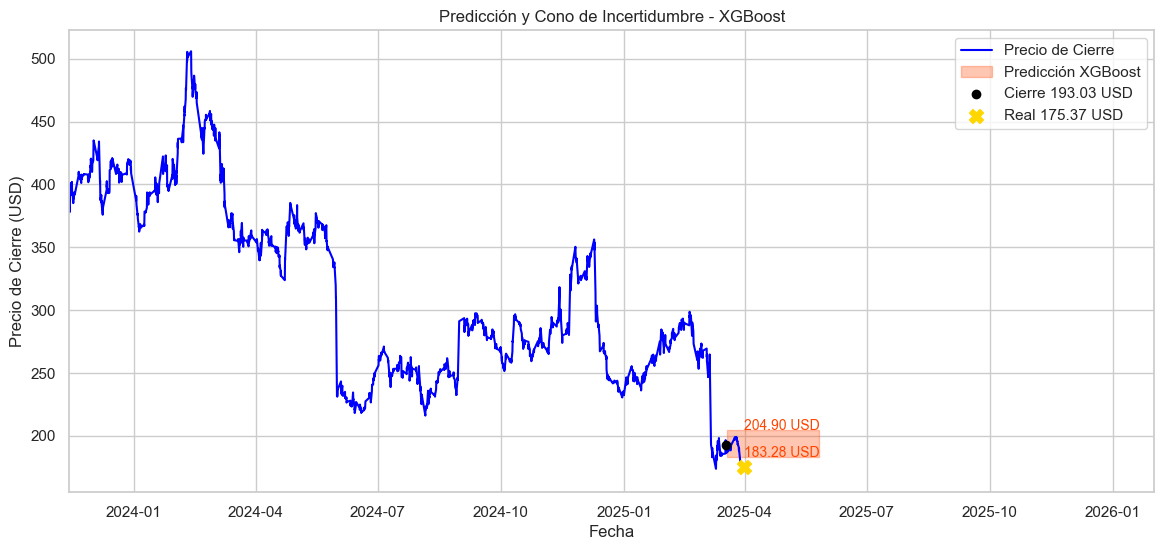

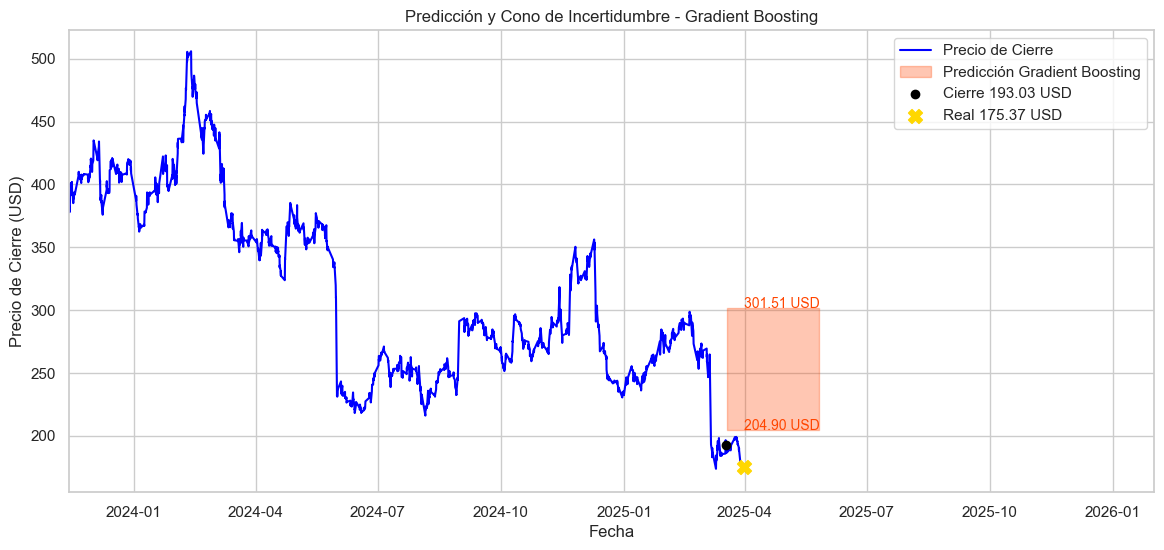

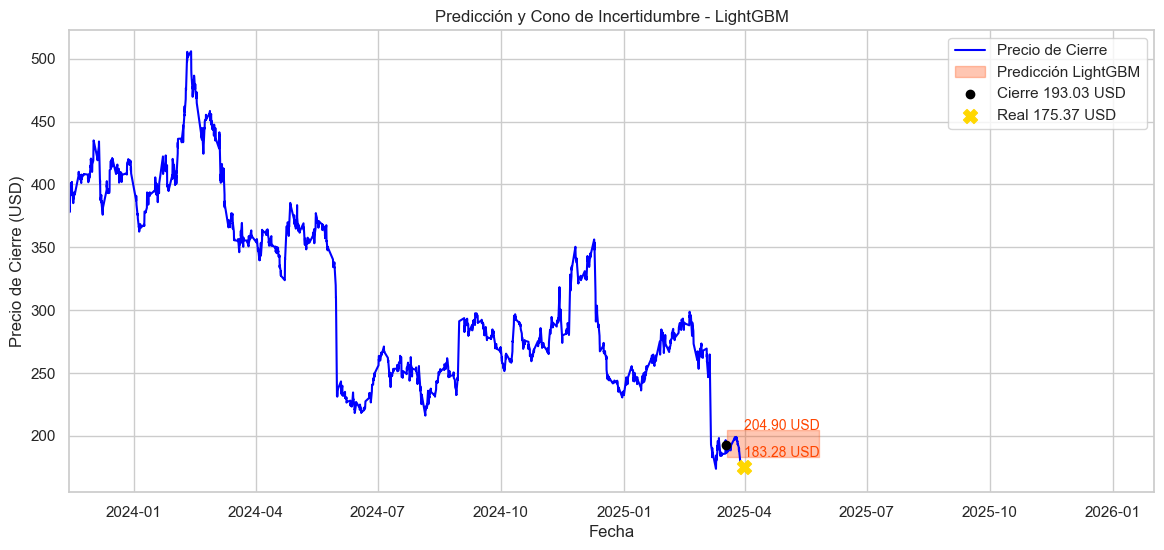

In [421]:
def check_prediction_with_cone(data, x, periods_ahead=70, num_days_to_plot=200):
    if -x >= len(data) or -x + periods_ahead >= len(data):
        print(f"‚ö†Ô∏è No hay suficientes datos para verificar {x} per√≠odos atr√°s.")
        return

    # üîπ Obtener datos del punto de partida
    specific_day_data = data.iloc[-x]
    specific_date = specific_day_data["Date"]
    close_actual = specific_day_data["Close"]
    
    min_change = abs(data_2w['Past_Change_2w'].min())  # Valor absoluto del m√≠nimo
    max_change = abs(data_2w['Past_Change_2w'].max())  # Valor absoluto del m√°ximo

    # üîπ Obtener datos del punto futuro donde se verificar√° la predicci√≥n
    future_day_data = data.iloc[-x + periods_ahead]
    future_date = future_day_data["Date"]
    close_future = future_day_data["Close"]

    # üîπ Calcular el cambio real en porcentaje
    real_change_percent = ((close_future - close_actual) / close_actual) * 100

    # üîπ Extraer caracter√≠sticas para la predicci√≥n
    features = [
        col
        for col in data.columns
        if col not in ["Future_Change_2w", "Future_Class_2w", "Date"]
    ]
    X_specific_day = specific_day_data[features]

    specific_day_predictions = {}
    projected_prices = {}

    for model_name, model in models.items():
        future_prediction = int(model.predict([X_specific_day])[0])
        specific_day_predictions[model_name] = future_prediction

        # üîπ Determinar el rango seg√∫n la predicci√≥n
        if future_prediction == 0:  # Ca√≠da muy fuerte
            color = "red"
            pred_range = (percentiles_2w[0] - min_change, percentiles_2w[0])
        elif future_prediction == 1:  # Ca√≠da moderada
            color = "orangered"
            pred_range = (percentiles_2w[0], percentiles_2w[1])
        else:  # Subida muy fuerte
            color = "green"
            pred_range = (percentiles_2w[1], percentiles_2w[1] + max_change)

        projected_price_min = close_actual * (1 + (pred_range[0] / 100))
        projected_price_max = close_actual * (1 + (pred_range[1] / 100))
        projected_prices[model_name] = (
            projected_price_min,
            projected_price_max,
            pred_range[0],
            pred_range[1],
        )

    # üìå Mostrar resultados
    print(f"\nüìÖ Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"üí∞ Cierre en la fecha evaluada: {close_actual:.2f} USD")
    print(f"üìÖ Fecha futura (2 semanas despu√©s): {future_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"üí∞ Cierre en la fecha futura: {close_future:.2f} USD")
    print(f"üìà Cambio real en porcentaje: {real_change_percent:.2f}%")

    print("\nüîç Predicciones de los modelos y precios proyectados:")
    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, percentile_min, percentile_max = projected_prices[model_name]

        if percentile_min <= real_change_percent <= percentile_max:
            resultado = "‚úÖ Acert√≥!"
        else:
            resultado = "‚ùå No acert√≥."

        print(f"{model_name}: Predicci√≥n = {prediction} | Rango esperado = {price_min:.2f} - {price_max:.2f} USD")
        print(f"üéØ Rango de percentiles: {percentile_min:.2f}% - {percentile_max:.2f}% -> {resultado}")

    # üöÄ Graficar con el cono de predicci√≥n (una gr√°fica por modelo)
    future_steps = periods_ahead
    future_dates = pd.date_range(start=specific_date, periods=future_steps + 1, freq="D")[1:]

    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, _, _ = projected_prices[model_name]

        # üîπ Graficar el historial del precio de cierre
        plt.figure(figsize=(14, 6))
        plt.plot(
            data.iloc[-num_days_to_plot:]["Date"],
            data.iloc[-num_days_to_plot:]["Close"],
            label="Precio de Cierre",
            color="blue",
        )

        # üîπ Graficar el cono de predicci√≥n
        lower_bound = [
            close_actual * (1 + (projected_prices[model_name][2] / 100))
        ] * len(future_dates)
        upper_bound = [
            close_actual * (1 + (projected_prices[model_name][3] / 100))
        ] * len(future_dates)

        plt.fill_between(
            future_dates,
            lower_bound,
            upper_bound,
            color=color,
            alpha=0.3,
            label=f"Predicci√≥n {model_name}",
        )

        # üîπ Etiquetas de los valores proyectados en el extremo derecho
        plt.text(
            future_dates[-1],
            lower_bound[-1],
            f"{lower_bound[-1]:.2f} USD",
            color=color,
            fontsize=10,
            ha="right",
        )
        plt.text(
            future_dates[-1],
            upper_bound[-1],
            f"{upper_bound[-1]:.2f} USD",
            color=color,
            fontsize=10,
            ha="right",
        )

        # üîπ Marcar el punto de inicio de la predicci√≥n y el cierre real futuro
        plt.scatter(
            specific_date,
            close_actual,
            color="black",
            zorder=3,
            label=f"Cierre {close_actual:.2f} USD",
        )
        plt.scatter(
            future_date,
            close_future,
            color="gold",
            marker="X",
            s=100,
            zorder=4,
            label=f"Real {close_future:.2f} USD",
        )

        # Configuraci√≥n del gr√°fico
        plt.xlabel("Fecha")
        plt.ylabel("Precio de Cierre (USD)")
        plt.title(f"Predicci√≥n y Cono de Incertidumbre - {model_name}")
        plt.legend()
        plt.grid(True)

        plt.xlim(
            data.iloc[-num_days_to_plot]["Date"],
            future_dates[-1] + pd.Timedelta(days=250),
        )
        plt.show()


# Llamada a la funci√≥n con los par√°metros deseados
check_prediction_with_cone(data_2w, x=73, periods_ahead=70, num_days_to_plot=2400)